In [1]:
import pandas as pd
from pandas_datareader import data

import numpy as np, numpy.random
from numpy import mean

import random

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

from datetime import datetime

from scipy.stats import norm 
from scipy.stats import shapiro
from scipy.stats import kstest
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy import stats

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

import pmdarima
import arch

from IPython.display import display, HTML

In [ ]:
#SCENARIO 1 : SINGLE STOCK

start_date = '2016-12-30'
end_date='2019-06-11'
forecast_end_date='2019-07-05'
backtest_duration=0 #day vs last day of available data
T=np.busday_count(end_date,forecast_end_date)+backtest_duration
N=T+1

percentile_range='P10_P90'
symbols=['1023.KL']
portfolioWeights=[1]

portfolioValue=5000

NoOfIterationsWeights=5000
NoOfIterationsMC=100
percentile_ranges="P10_P90"
riskfreerateannual=0.0081 


In [ ]:
#SCENARIO 2 : SINGLE STOCK BACKTEST ZERO

start_date = '2017-07-11'
end_date='2020-05-08'
forecast_end_date='2020-05-21'
backtest_duration=20 #day vs last day of available data
T=np.busday_count(end_date,forecast_end_date)+backtest_duration
N=T+1

percentile_range='P10_P90'
symbols=['C09.SI']
portfolioWeights=[1]

portfolioValue=5000

NoOfIterationsWeights=5000
NoOfIterationsMC=100
percentile_ranges="P10_P90"
riskfreerateannual=0.0081 

In [ ]:
#SCENARIO 3 : MORE THAN ONE STOCK

start_date = '2017-01-02'
end_date='2020-12-10'
#forecast_end_date='2021-12-31'
forecast_end_date='2021-10-14'
backtest_duration=30 #day vs last day of available data
T=np.busday_count(end_date,forecast_end_date)+backtest_duration
N=T+1

symbols=['MDLZ','NFLX','IBM','FB']
portfolioWeights=[0.3,0.3,0.2,0.2]

portfolioValue=10000

NoOfIterationsWeights=5000
NoOfIterationsMC=100
percentile_range="P10_P90"


In [ ]:
#SCENARIO 4 : MORE THAN ONE STOCK

start_date = '2017-01-02'
end_date='2020-12-10'
forecast_end_date='2020-12-31'
backtest_duration=0 #day vs last day of available data
T=np.busday_count(end_date,forecast_end_date)+backtest_duration
N=T+1

symbols=['FB','NVDA','AMZN','NFLX','GOOG']
portfolioWeights=[0.3,0.1,0.2,0.2,0.2]

portfolioValue=5000

NoOfIterationsWeights=5000
NoOfIterationsMC=100
percentile_range="P10_P90"

In [2]:
#Based loosely on https://towardsdatascience.com/how-to-simulate-financial-portfolios-with-python-d0dc4b52a278

def extract_prices(start_date,end_date,symbols,portfolioWeights,portfolioValue,backtestduration=0):
    dim=len(symbols)
    for symbol in symbols:
        dfprices = data.DataReader(symbols, start=start_date, end=end_date, data_source='yahoo')
        dfprices = dfprices[['Adj Close']]
    dfprices.columns=[' '.join(col).strip() for col in dfprices.columns.values]

    priceAtEndDate=[]
    for symbol in symbols:
        priceAtEndDate.append(dfprices[[f'Adj Close {symbol}']][-(backtestduration+1):].values[0][0])
        
    noOfShares=[]
    portfolioValPerSymbol=[x * portfolioValue for x in portfolioWeights]
    for i in range(0,len(symbols)):
        noOfShares.append(portfolioValPerSymbol[i]/priceAtEndDate[i])
    noOfShares=[round(element, 5) for element in noOfShares]
    listOfColumns=dfprices.columns.tolist()   
    dfprices["Adj Close Portfolio"]=dfprices[listOfColumns].mul(noOfShares).sum(1)
    
    share_split_table=dfprices.tail(1).T
    share_split_table=share_split_table.iloc[:-1]
    share_split_table["Share"]=symbols
    share_split_table["No Of Shares"]=noOfShares
    share_split_table.columns=["Price At "+end_date,"Share Name","No Of Shares"]
    share_split_table["Value At "+end_date]=share_split_table["No Of Shares"]*share_split_table["Price At "+end_date]
    share_split_table.index=share_split_table["Share Name"]
    share_split_table=share_split_table[["Share Name","Price At "+end_date,"No Of Shares","Value At "+end_date]]
    share_split_table=share_split_table.round(3)
    share_split_table=share_split_table.append(share_split_table.sum(numeric_only=True), ignore_index=True)
    share_split_table.at[len(symbols),'No Of Shares']=np.nan
    share_split_table.at[len(symbols),'Price At '+end_date]=np.nan
    share_split_table.at[len(symbols),'Share Name']="Portfolio"
    share_split_table["Weights"]=portfolioWeights+["1"]
    share_split_table = share_split_table[['Share Name', 'Weights', 'Price At '+end_date, 'No Of Shares', "Value At "+end_date]] 
    
    print(f"Extracted {len(dfprices)} days worth of data for {len(symbols)} counters with {dfprices.isnull().sum().sum()} missing data")
    
    return dfprices, noOfShares, share_split_table

In [ ]:
dfprices, noOfShares, share_split_table = extract_prices(start_date,end_date,symbols,portfolioWeights,portfolioValue)

In [3]:
def plotprices(dfprices,symbols,imagecounter,targetfolder):
    dfprices.plot(subplots=True, figsize=(15,7.5*len(symbols)))
    plt.savefig(f'static/{targetfolder}/{imagecounter}_02adjclosingprices.png')

In [ ]:
plotprices(dfprices,symbols,"05678","analysis")

In [4]:
def plotpiechart(symbols,portfolioWeights,imagecounter,targetfolder):    
    labels = symbols
    sizes = portfolioWeights
    fig1, ax1 = plt.subplots()
    ax1.pie(portfolioWeights, labels=symbols, autopct='%1.1f%%',
        shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title("Portfolio Weights")
    plt.savefig(f'static/{targetfolder}/{imagecounter}_01portfolioweights.png')

In [5]:
#Modified from https://medium.com/swlh/generating-candlestick-charts-from-scratch-ef6e1d3cf0e9

# Function to draw candlestick
def draw_candlestick(axis, data, color_up, color_down):
    
    # Check if stock closed higher or not
    if data['Close'] > data['Open']:
        color = color_up
    else:
        color = color_down

    # Plot the candle wick
    axis.plot([data['day_num'], data['day_num']], [data['Low'], data['High']], linewidth=2, color='black', solid_capstyle='round', zorder=2)
    
    # Draw the candle body
    rect = mpl.patches.Rectangle((data['day_num'] - 0.5, data['Open']), 1.0, (data['Close'] - data['Open']), facecolor=color, edgecolor='black', linewidth=1, zorder=3)

    # Add candle body to the axis
    axis.add_patch(rect)
    
    # Return modified axis
    return axis

# Function to draw all candlesticks
def draw_all_candlesticks(axis, data, color_up='white', color_down='black'):
    for day in range(data.shape[0]):
        axis = draw_candlestick(axis, data.iloc[day], color_up, color_down)
    return axis

def plot_candlesticks(symbols,start_date,end_date,imagecounter,targetfolder):
    for i in range(0,len(symbols)):
        tkr_str = str(symbols[i])
        tkr_history = data.DataReader(tkr_str, start=start_date, end=end_date, data_source='yahoo')
        tkr_history['Date']=tkr_history.index
        base_date = tkr_history['Date'][0]
        tkr_history['day_num'] = tkr_history['Date'].map(lambda date:(date - base_date).days)

        # Create figure and axes
        fig = plt.figure(figsize=(20, 10), facecolor='white')
        ax = fig.add_subplot(111)

        # Colors for candlesticks
        colors = ['#00FF00', '#FF0000']

        # Grid lines
        ax.grid(linestyle='-', linewidth=4, color='white', zorder=1)

        # Draw candlesticks
        ax = draw_all_candlesticks(ax, tkr_history, colors[0], colors[1])

        # Set ticks to every 5th day
        ax.set_xticks(list(tkr_history['day_num'])[::15])
        ax.set_xticklabels(list(tkr_history['Date'].dt.strftime('%Y-%m-%d'))[::15])
        ax.tick_params(labelsize=14)
        plt.xticks(rotation=50)

#         # Add dollar signs
#         formatter = mpl.ticker.FormatStrFormatter('$%.2f')
#         ax.yaxis.set_major_formatter(formatter)

        # Append ticker symbol
        ax.text(0, 1.05, tkr_str, va='baseline', ha='left', size=20, transform=ax.transAxes)

        # Set axis limits
        ax.set_xlim(-1, tkr_history['day_num'].iloc[-1] + 1)

        # Show plot
        plt.savefig(f'static/{targetfolder}/{imagecounter}_candlestick{i}.png')
        plt.show()
        

In [ ]:
plot_candlesticks(symbols,start_date,end_date,"05678","candlesticks")

In [6]:
#Modified from https://tcoil.info/compute-bollinger-bands-for-stocks-with-python-and-pandas/

    # n = smoothing length eg 20
    # m = number of standard deviations away from MA eg 2
    
def bollinger_bands(start_date,end_date,symbol, n, m,i):

    df=data.DataReader(symbol, start=start_date, end=end_date, data_source='yahoo')
    
    #typical price
    TP = (df['High'] + df['Low'] + df['Close']) / 3
    # but we will use Adj close instead for now, depends
    
    datax = TP
    #data = df['Adj Close']
    
    # takes one column from dataframe
    B_MA = pd.Series((datax.rolling(n, min_periods=n).mean()), name='B_MA')
    sigma = datax.rolling(n, min_periods=n).std() 
    
    BU = pd.Series((B_MA + m * sigma), name='BU')
    BL = pd.Series((B_MA - m * sigma), name='BL')
    
    df = df.join(B_MA)
    df = df.join(BU)
    df = df.join(BL)  
    
    return df

def plot_bollingerbands(symbols,start_date,end_date,n,m,imagecounter,targetfolder):
    for i in range(0,len(symbols)):
        df=bollinger_bands(start_date,end_date,str(symbols[i]), n, m,i)
        # plot correspondingRSI values and significant levels
        plt.figure(figsize=(15,5))
        plt.title(symbols[i]+': Bollinger Bands For Smoothing Length Of '+str(n)+' Days & '+str(m)+' Std Devs From MA')
        plt.plot(df.index, df['Adj Close'])
        plt.plot(df.index, df['BU'], alpha=0.3)
        plt.plot(df.index, df['BL'], alpha=0.3)
        plt.plot(df.index, df['B_MA'], alpha=0.3)
        plt.fill_between(df.index, df['BU'], df['BL'], color='grey', alpha=0.1)
        plt.savefig(f'static/{targetfolder}/{imagecounter}_bollingerband{i}.png')
        plt.show()

In [ ]:
plot_bollingerbands(symbols,start_date,end_date,20,2,'12345','bollingerbands')

In [7]:
#Modified from https://stackoverflow.com/questions/20526414/relative-strength-index-in-python-pandas

def calcRSI(start_date,end_date,symbol,time_window,RSItype="EWMA"):

    df=data.DataReader(symbol, start=start_date, end=end_date, data_source='yahoo')
    
    diff = df["Adj Close"].diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=time_window-1 so we get decay alpha=1/time_window
    if RSItype=="EWMA":
        up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window, adjust=False).mean()
        down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window, adjust=False).mean()
    
    elif RSItype=="SMA":
    # Calculate the SMA
        up_chg_avg = up_chg.rolling(time_window).mean()
        down_chg_avg = down_chg.abs().rolling(time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    df["RSI"]=rsi
    return df

In [8]:
def plot_RSI(symbols,start_date,end_date,time_window,RSItype,imagecounter,targetfolder):
    for i in range(0,len(symbols)):
        dfrsi=calcRSI(start_date,end_date,str(symbols[i]),time_window,RSItype)
        plt.figure(figsize=(15,5))
        dfrsi['Adj Close'][time_window::].plot()
        plt.title(str(symbols[i])+": Adj Close Price")
        plt.savefig(f'static/{targetfolder}/{imagecounter}_{i}adjclosingprice.png')
        plt.show
        
        plt.figure(figsize=(15,5))
        dfrsi["RSI"].plot()
        plt.axhline(0, linestyle='--', alpha=0.1)
        plt.axhline(20, linestyle='--', alpha=0.5)
        plt.axhline(30, linestyle='--')
        plt.axhline(70, linestyle='--')
        plt.axhline(80, linestyle='--', alpha=0.5)
        plt.axhline(100, linestyle='--', alpha=0.1)
        plt.title(str(symbols[i])+": RSI Plot: "+RSItype+" With Period Of "+str(time_window)+" Days")
        plt.savefig(f'static/{targetfolder}/{imagecounter}_{i}relativestrengthindex.png')
        plt.show()


In [ ]:
# When RSI values are:

# above 70, asset is considered overbought (overvalued)
# below 30, asset is considered oversold (undervalued)
# Even better is to look at divergence between price and RSI values:

# bullish divergence: price is trending down, RSI values are increasing (possible Long entry)
# bearish divergence: price is th=rending up, RSI values are decreasing (possible Short entry)


plot_RSI(symbols,start_date,end_date,14,"EWMA","3456","relativestrengthindex")

In [9]:
def calcMACD(start_date,end_date,symbol,timeperiod1,timeperiod2,timeperiod3,imagecounter,targetfolder):
    df=data.DataReader(symbol, start=start_date, end=end_date, data_source='yahoo')
    
    df["EWMA "+str(timeperiod1)+" Days"]=df["Adj Close"].ewm(span=timeperiod1,min_periods=timeperiod1,adjust=False,ignore_na=False).mean()
    df["EWMA "+str(timeperiod2)+" Days"]=df["Adj Close"].ewm(span=timeperiod2,min_periods=timeperiod2,adjust=False,ignore_na=False).mean()
    df["MACD"]=df["EWMA "+str(timeperiod1)+" Days"]-df["EWMA "+str(timeperiod2)+" Days"]
    df["Signal Line"]=df["MACD"].ewm(span=timeperiod3,min_periods=timeperiod3,adjust=False,ignore_na=False).mean()
    
    
    df[['Adj Close',"EWMA "+str(timeperiod1)+" Days","EWMA "+str(timeperiod2)+" Days"]].plot(figsize=(15,5))
    plt.title(symbol+": MACD ("+str(timeperiod1)+","+str(timeperiod2)+","+str(timeperiod3)+") - EWMAs & Adj Close Price")
    plt.savefig(f'static/{targetfolder}/{imagecounter}_{symbol}_1_MACD.png')
    
    df[["MACD","Signal Line"]].plot(figsize=(15,5))
    plt.title(symbol+": MACD ("+str(timeperiod1)+","+str(timeperiod2)+","+str(timeperiod3)+") - MACD & Signal Line")
    plt.savefig(f'static/{targetfolder}/{imagecounter}_{symbol}_2_MACD.png')
    
    df["Histogram"]=df["MACD"]-df["Signal Line"]
    df.plot.bar(y='Histogram',figsize=(15,5))
    tick_spacing = 28
    plt.gca().xaxis.set_major_locator(plt.AutoLocator())
    plt.title(symbol+": MACD ("+str(timeperiod1)+","+str(timeperiod2)+","+str(timeperiod3)+") - MACD Histogram")
    
    #plt.savefig(f'static/{targetfolder}/{imagecounter}_{symbol}_3_MACD.png')

In [10]:
def plot_MACD(start_date,end_date,symbols,timeperiod1,timeperiod2,timeperiod3,imagecounter,targetfolder):
    for symbol in symbols:
        calcMACD(start_date,end_date,symbol,timeperiod1,timeperiod2,timeperiod3,imagecounter,targetfolder)

     

In [11]:
def calc_returns(dfprices,symbols):
    dfreturns=pd.DataFrame()
    columns = list(dfprices) 
    mean=[]
    stdev=[]
    for column in columns:
        dfreturns[f'Log Daily Returns {column}']=np.log(dfprices[column]).diff()
        mean.append(dfreturns[f'Log Daily Returns {column}'][1:].mean())
        stdev.append(dfreturns[f'Log Daily Returns {column}'][1:].std())
    dfreturns=dfreturns.dropna()
    
    if len(dfreturns.columns)==1:
        df_mean_stdev=pd.DataFrame(list(zip(symbols,mean,stdev)),columns =['Stock', 'Mean Log Daily Return','StdDev Log Daily Return']) 
    else:
        df_mean_stdev=pd.DataFrame(list(zip(symbols+["Portfolio"],mean,stdev)),columns =['Stock', 'Mean Log Daily Return','StdDev Log Daily Return'])
    
    return dfreturns ,df_mean_stdev

In [ ]:
dfreturns ,df_mean_stdev=calc_returns(dfprices,symbols)

In [ ]:
df_mean_stdev

In [12]:
#Correlations which are within the blue bands are not statistically significant
def plotACFPACF(series,imagecounter,targetfolder):
    
    for i in range(0,len(series.columns)):
        
        plt.figure(figsize=(15,5))
        Prices=series[series.columns[i]].plot()
        plt.title(series.columns[i])
        plt.savefig(f'static/{targetfolder}/{imagecounter}_{i}_Price.png')
        
        fig1, ax1 = plt.subplots(figsize=(15, 5))
        ACFplot=plot_acf(series[series.columns[i]], lags=30, ax=ax1)
        plt.title(series.columns[i]+' ACF')
        plt.savefig(f'static/{targetfolder}/{imagecounter}_{i}_PriceACF.png')
        
        fig2, ax2 = plt.subplots(figsize=(15, 5))
        PACFplot=plot_pacf(series[series.columns[i]], lags=30,ax=ax2)
        plt.title(series.columns[i]+' PACF')
        plt.savefig(f'static/{targetfolder}/{imagecounter}_{i}_PricePACF.png')
        

In [ ]:
plotACFPACF(dfreturns,"125435","ACFPACF")

In [13]:
def convertReturnsToPrices(dfreturns,startingrefprice):
    stockprices=pd.DataFrame()
    stockprices=np.exp(dfreturns)
    stockprices=stockprices.cumprod()
    stockprices=stockprices.mul(startingrefprice.values)
    stockprices.columns=stockprices.columns.str.lstrip('Log Daily Returns ')
    firstrow=pd.DataFrame(startingrefprice)
    stockprices=pd.concat([firstrow,stockprices])
    return stockprices


In [14]:
def plotreturns(dfreturns,imagecounter,targetfolder):
    dfreturns.plot(subplots=True, figsize=(15,7.5*len(dfreturns.columns)))
    plt.savefig(f'static/{targetfolder}/{imagecounter}_03Dailyreturns.png')

In [ ]:
plotreturns(dfreturns,"05678","analysis")

In [ ]:
dfreturns.corr().round(4)


In [15]:
def compareStartMidEnd(dfreturns,df_mean_stdev):

    #print ('Size of dataFrame=', len(dfreturns.index))
    desired_number_of_groups = 3
    group_size = int(len(dfreturns.index) / (desired_number_of_groups))
    #print("group_size=", group_size)
    remainder_size = len(dfreturns.index) % group_size
    #print("remainder_size=", remainder_size)
    df_split_list = [dfreturns.iloc[i:i + group_size] for i in range(0, len(dfreturns) - group_size + 1, group_size)]
    #print("Number of split_dataframes=", len(df_split_list))
    if remainder_size > 0:
        df_remainder = dfreturns.iloc[-remainder_size:len(dfreturns.index)]
        df_split_list.append(df_remainder)
    #print("Revised Number of split_dataframes=", len(df_split_list))
    #print("Splitting complete, verifying counts")

    count_all_rows_after_split = 0
    for index, split_df in enumerate(df_split_list):
        #print("split_df:", index, " size=", len(split_df.index))
        count_all_rows_after_split += len(split_df.index)

    if count_all_rows_after_split != len(dfreturns.index):
        raise Exception('rows_after_split = ', count_all_rows_after_split," but original CSV DataFrame has count =", len(dfreturns.index))

    columns =['Stock','Start Mean', 'Start StdDev','Middle Mean','Middle StdDev','End Mean','End StdDev']
    
    anothertable=[]
    for i in range(0,len(dfreturns.columns)):
        boxplotsplit=pd.DataFrame()
        boxplotsplit["Start"]=df_split_list[0].iloc[:,i].values
        boxplotsplit["Middle"]=df_split_list[1].iloc[:,i].values
        boxplotsplit["End"]=df_split_list[2].iloc[:,i].values
        #means = [boxplotsplit["Start"].mean(),boxplotsplit["Middle"].mean(),boxplotsplit["End"].mean()]
        #std =  [boxplotsplit["Start"].std(),boxplotsplit["Middle"].std(),boxplotsplit["End"].std()]
        meanstdev=[dfreturns.columns[i],boxplotsplit["Start"].mean(),boxplotsplit["Start"].std(),\
                   boxplotsplit["Middle"].mean(),boxplotsplit["Middle"].std(),\
                   boxplotsplit["End"].mean(),boxplotsplit["End"].std()]
        
        anothertable.append(meanstdev) 
        
    yetanothertable=pd.DataFrame(anothertable,columns=columns)
    
    yetanothertable["Overall Mean"]=df_mean_stdev["Mean Log Daily Return"]
    yetanothertable["Overall StdDev"]=df_mean_stdev["StdDev Log Daily Return"]
    yetanothertable=yetanothertable[['Stock','Overall Mean', 'Start Mean','Middle Mean','End Mean',\
                                     'Overall StdDev','Start StdDev','Middle StdDev','End StdDev']]
    
    return yetanothertable
        

In [ ]:
StartMidEndMeanStdev=compareStartMidEnd(dfreturns,df_mean_stdev)
StartMidEndMeanStdev.round(4)

In [16]:
def fit_test_normal(dfreturns,symbols,imagecounter,targetfolder):
    
    columnlist=dfreturns.columns
    KSTestResults=[]
    KSPValResults=[]
    for column in columnlist:
        data=(dfreturns[column])
        normed_data=(data-dfreturns[column].mean())/dfreturns[column].std()
        KSTestResults.append(kstest(normed_data, 'norm')[0])
        KSPValResults.append(kstest(normed_data, 'norm')[1])
    if len(dfreturns.columns)==1:
        KSTestResultsDF=pd.DataFrame([dfreturns.columns,KSTestResults,KSPValResults]).T
    else:
        KSTestResultsDF=pd.DataFrame([dfreturns.columns,KSTestResults,KSPValResults]).T
    KSTestResultsDF.columns=["Share Name","KS Test Statistic","KS Test P-Value"]
    KSTestResultsDF["Accept/Reject At 5% Signif Lvl"]=np.where(KSTestResultsDF['KS Test P-Value']> 0.05, "Data looks normal (Fail to reject H0)", "Data does NOT look normal (Reject H0)")
    
    ShapiroWilkTestStats=[]
    ShapiroWilkTestPValue=[]
    for column in columnlist:
        data=(dfreturns[column])
        stat, pvalue = shapiro(data)
        ShapiroWilkTestStats.append(stat)
        ShapiroWilkTestPValue.append(round(pvalue,6))

    ShapiroWilkTestResultsDF=pd.DataFrame([ShapiroWilkTestStats,ShapiroWilkTestPValue]).T
    if len(dfreturns.columns)==1:
        ShapiroWilkTestResultsDF["Share Name"]=dfreturns.columns
    else:
        ShapiroWilkTestResultsDF["Share Name"]=dfreturns.columns
    ShapiroWilkTestResultsDF.columns=["SW Test Statistic","SW Test P-Value","Share Name"]
    ShapiroWilkTestResultsDF=ShapiroWilkTestResultsDF[["Share Name","SW Test Statistic","SW Test P-Value"]]
    ShapiroWilkTestResultsDF["Accept/Reject At 5% Signif Lvl"]=np.where(ShapiroWilkTestResultsDF['SW Test P-Value']> 0.05, "Data looks normal (Fail to reject H0)", "Data does NOT look normal (Reject H0)")

    
    ADFTestStats=[]
    ADFTestCritValue=[]
    for column in columnlist:
        data=(dfreturns[column])        
        ADFTest_result = adfuller(data)
        ADFTestStats.append(ADFTest_result[0])
        ADFTestCritValue.append(ADFTest_result[4]['5%'])

    ADFTestResultsDF=pd.DataFrame([ADFTestStats,ADFTestCritValue]).T
    ADFTestResultsDF["Share Name"]=dfreturns.columns
    ADFTestResultsDF.columns=["ADF Test Statistic","ADF Test Stat Crit Value At 5% Signif Lvl","Share Name"]
    ADFTestResultsDF=ADFTestResultsDF[["Share Name","ADF Test Statistic","ADF Test Stat Crit Value At 5% Signif Lvl"]]
    ADFTestResultsDF["Accept/Reject At 5% Signif Lvl"]=np.where(ADFTestResultsDF['ADF Test Statistic']> ADFTestResultsDF['ADF Test Stat Crit Value At 5% Signif Lvl'] , "Time series is NON-stationary (Reject H0)", "Time series is stationary (Fail To Reject H0)")  
        
    skewArray=[]
    kurtosisArray=[]
    for column in columnlist:
        data=(dfreturns[column])
        skewArray.append(skew(data))
        kurtosisArray.append(kurtosis(data))
        mu = np.mean(data)
        sigma = np.std(data)
        plt.figure(figsize = (15, 5))
        plt.hist(data, bins=50, density=True, alpha=0.6, color='g')
        # Plot the PDF.
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, sigma)
        plt.plot(x, p, 'k', linewidth=2)
        title = column+" Histogram vs Best Fit Normal Distribution Mu = %.3f,  Sigma = %.3f" % (mu, sigma)
        plt.title(title)
        plt.savefig(f'static/{targetfolder}/{imagecounter}_04histogram{column}.png')
    
    Kurtosis_Skew=pd.DataFrame(list(zip(skewArray, kurtosisArray)), 
               index=columnlist,columns =['Skew','Kurtosis']) 
    
#     If the skewness is between -0.5 and 0.5, the data are fairly symmetrical.
#     If the skewness is between -1 and – 0.5 or between 0.5 and 1, the data are moderately skewed.
#     If the skewness is less than -1 or greater than 1, the data are highly skewed.
    def skewconditions(s):
        if (s['Skew'] > 1) :
            return "Highly Positively Skewed"
        elif (s['Skew'] <= 1) and (s['Skew'] > 0.5) :
            return "Moderately Positively Skewed"
        elif (s['Skew'] <= 0.5) and (s['Skew'] > -0.5) :
            return "Fairly Symmetrical"
        elif (s['Skew'] <= -0.5) and (s['Skew'] > -1.0) :
            return "Moderately Negatively Skewed"
        elif (s['Skew'] <= -1.0) :
            return "Highly Negatively Skewed"
    
#     For kurtosis, the general guideline is that if the number is greater than +1, the distribution is too peaked. 
#     Likewise, a kurtosis of less than –1 indicates a distribution that is too flat
    def kurtosisconditions(s):
        if (s['Kurtosis'] > 3) :
            return "Leptokurtic:Peaked & Fat Tailed"
        elif (s['Kurtosis'] <-3):
            return "Platykurtic:Flat & Thin Tailed"
        else :
            return "Mesokurtic"
    
    Kurtosis_Skew['Skew Description'] = Kurtosis_Skew.apply(skewconditions, axis=1)
    Kurtosis_Skew['Kurtosis Description'] = Kurtosis_Skew.apply(kurtosisconditions, axis=1)
    
    for i in range(0,len(columnlist)):
        data=(dfreturns.iloc[:, i])
        res = stats.probplot(data, dist="norm")
        xxx=pd.DataFrame(list(zip(res[0][0],res[0][1])),columns =["Theoretical Quantiles","Ordered Values"]) 
        xxx.plot.scatter(x="Theoretical Quantiles",y="Ordered Values",title=columnlist[i],figsize = (7.5, 5))
        plt.plot(xxx["Theoretical Quantiles"], res[1][0]*xxx["Theoretical Quantiles"]+res[1][1])
        plt.savefig(f'static/{targetfolder}/{imagecounter}_05qqplot{i}.png')
    
    return KSTestResultsDF, ShapiroWilkTestResultsDF, Kurtosis_Skew, ADFTestResultsDF

In [ ]:
KSTestResultsDF, ShapiroWilkTestResultsDF , Kurtosis_Skew, ADFTestResultsDF = fit_test_normal(dfreturns,symbols,"05678","analysis")

In [ ]:
display(KSTestResultsDF)
display(ShapiroWilkTestResultsDF)
display(Kurtosis_Skew)
display(ADFTestResultsDF)

In [17]:
def bootstrap_w_replc_singleval(dfreturns):
    columns=dfreturns.columns
    singlesample=pd.DataFrame(dfreturns.values[np.random.randint(len(dfreturns), size=1)], columns=columns)
    return singlesample


In [18]:
def bootstrapforecast(dfreturns,T):
    columnlist=dfreturns.columns
    X=[]
    for i in range(0,T):
        X.append(bootstrap_w_replc_singleval(dfreturns).values.tolist()[0])
    Y=pd.DataFrame(X)
    Y.columns=columnlist
    Y.loc[-1] = [0]*len(columnlist)  # adding a row
    Y.index = Y.index + 1  # shifting index
    Y = Y.sort_index()  # sorting by index
    
    return Y

In [19]:
#Adapted from https://stackoverflow.com/questions/10939213/how-can-i-calculate-the-nearest-positive-semi-definite-matrix

#import numpy as np,numpy.linalg

def _getAplus(A):
    eigval, eigvec = np.linalg.eig(A)
    Q = np.matrix(eigvec)
    xdiag = np.matrix(np.diag(np.maximum(eigval, 0)))
    return Q*xdiag*Q.T

def _getPs(A, W=None):
    W05 = np.matrix(W**.5)
    return  W05.I * _getAplus(W05 * A * W05) * W05.I

def _getPu(A, W=None):
    Aret = np.array(A.copy())
    Aret[W > 0] = np.array(W)[W > 0]
    return np.matrix(Aret)

def nearPD(A, nit=10):
    n = A.shape[0]
    W = np.identity(n) 
# W is the matrix used for the norm (assumed to be Identity matrix here)
# the algorithm should work for any diagonal W
    deltaS = 0
    Yk = A.copy()
    for k in range(nit):
        Rk = Yk - deltaS
        Xk = _getPs(Rk, W=W)
        deltaS = Xk - Rk
        Yk = _getPu(Xk, W=W)
    return Yk

In [20]:
def create_covar(dfreturns):  
    try:
        returns=[]
        arrOfReturns=[]
        columns = list(dfreturns)
        for column in columns:
            returns=dfreturns[column].values.tolist()
            arrOfReturns.append(returns)
        Cov = np.cov(np.array(arrOfReturns))    
        return Cov
    except LinAlgError :
        Cov = nearPD(np.array(arrOfReturns), nit=10)
        print("WARNING -Original Covariance Matrix is NOT Positive Semi Definite And Has Been Adjusted To Allow For Cholesky Decomposition ")
        return Cov

In [ ]:
COVARIANCE_MATRIX=pd.DataFrame(create_covar(dfreturns),index=dfreturns.columns,columns=dfreturns.columns)
COVARIANCE_MATRIX

In [ ]:
A = np.linalg.cholesky(COVARIANCE_MATRIX)
A

In [ ]:
CORRELATION_MATRIX=dfreturns.corr()
CORRELATION_MATRIX

In [21]:
def GBMsimulatorUniVar(So, mu, sigma, T, N):
    """
    Parameters

    seed:   seed of simulation
    So:     initial stocks' price
    mu:     expected return
    sigma:  volatility
    Cov:    covariance matrix
    T:      time period
    N:      number of increments
    """

    #np.random.seed(seed) turned off so Monte Carlo can be "randomised"
    dim = np.size(So)
    t = np.linspace(0., T, int(N))
    S = np.zeros([dim, int(N)])
    S[:, 0] = So
    for i in range(1, int(N)):    
        drift = (mu - 0.5 * sigma**2) * (t[i] - t[i-1])
        Z = np.random.normal(0., 1., dim)
        diffusion = sigma* Z * (np.sqrt(t[i] - t[i-1]))
        S[:, i] = S[:, i-1]*np.exp(drift + diffusion)
    return S, t

In [22]:
def GBMsimulatorMultiVar(So, mu, sigma, Cov, T, N):
    """
    Parameters

    seed:   seed of simulation
    So:     initial stocks' price
    mu:     expected return
    sigma:  volatility
    Cov:    covariance matrix
    T:      time period
    N:      number of increments
    """

    #np.random.seed(seed) turned off so Monte Carlo can be "randomised"
    dim = np.size(So)
    t = np.linspace(0., T, int(N))
    A = np.linalg.cholesky(Cov)
    S = np.zeros([dim, int(N)])
    S[:, 0] = So
    for i in range(1, int(N)):    
        drift = (mu - 0.5 * sigma**2) * (t[i] - t[i-1])
        Z = np.random.normal(0., 1., dim)
        diffusion = np.matmul(A, Z) * (np.sqrt(t[i] - t[i-1]))
        S[:, i] = S[:, i-1]*np.exp(drift + diffusion)
    return S, t

In [23]:
def calculateRMSE(final,T,backtest_duration,dfprices):
    xyz=final.tail(T)
    xyz=xyz.head(backtest_duration)
    xyz
    qrs=pd.DataFrame(index=xyz.index)
    for i in range(0,len(dfprices.columns)):
        x=1+(len(dfprices.columns)-i)*-3
        qrs["Actual "+dfprices.columns[i]]=xyz.iloc[:,i]
        qrs["P50 "+dfprices.columns[i]]=xyz.iloc[:,x]
    for i in range(0,len(dfprices.columns)):
        x=i*2
        qrs["RMSE "+dfprices.columns[i]]=(qrs.iloc[:,x]-qrs.iloc[:,x+1])**2
    qrs
    RMSE=[]

    for i in range(0,len(dfprices.columns)):
        z=-(len(dfprices.columns)-i)
        RMSE.append((qrs.iloc[:,z].mean())**0.5)
    RMSE_DF=pd.DataFrame(RMSE,index=[dfprices.columns],columns=["RMSE For Backtest From "+qrs.index[0].strftime("%Y-%m-%d")+" To "+qrs.index[-1].strftime("%Y-%m-%d")\
                                                               +" ("+str(len(qrs))+" Days)"])
    return RMSE_DF

In [24]:
def MonteCarlo_GBM(start_date,end_date,backtest_duration,percentile_range,symbols,\
                       portfolioWeights,portfolioValue,T,N,NoOfIterationsMC,imagecounter,targetfolder):
    
    forecastresults=pd.DataFrame()
    percentiles=pd.DataFrame()
    
    extended_dates_future=[]
    lowerpercentile=int(percentile_range[1:3])
    upperpercentile=int(percentile_range[5:7])
 
    plotpiechart(symbols,portfolioWeights,imagecounter,targetfolder)

    if len(symbols)==1:
        dfpricesFULL, noOfSharesFULL, share_split_tableFULL = extract_prices(start_date,end_date,symbols,portfolioWeights,portfolioValue)
        backtest_end_date=dfpricesFULL.index[-(backtest_duration+1)].strftime("%Y-%m-%d")
        dfprices, noOfShares, share_split_table = extract_prices(start_date,backtest_end_date,symbols,portfolioWeights,portfolioValue)
        dfprices["Adj Close Portfolio"]=dfprices[list(dfprices.iloc[:,:-1].columns)].mul(noOfSharesFULL).sum(1)
        
    else:
        dfpricesFULL, noOfSharesFULL, share_split_tableFULL = extract_prices(start_date,end_date,symbols,portfolioWeights,portfolioValue)
        backtest_end_date=dfpricesFULL.index[-(backtest_duration+1)].strftime("%Y-%m-%d")
        dfprices, noOfShares, share_split_table = extract_prices(start_date,backtest_end_date,symbols,portfolioWeights,portfolioValue)
        dfprices["Adj Close Portfolio"]=dfprices[list(dfprices.iloc[:,:-1].columns)].mul(noOfSharesFULL).sum(1)
                  
    symbolsWPortfolio=symbols+["Portfolio"]

    dfreturns ,df_mean_stdev = calc_returns(dfprices,symbolsWPortfolio)
    
    S0=np.array(dfprices.tail(1).values.tolist()[0])
    mu=np.array(df_mean_stdev["Mean Log Daily Return"].values.tolist())
    sigma=np.array(df_mean_stdev["StdDev Log Daily Return"].values.tolist())   

    backtestdateslist=(list((dfpricesFULL.tail(backtest_duration+1).index)))
    backtestdates=[]
    for i in backtestdateslist:
        backtestdates.append(np.datetime64(datetime.strptime(str(i), '%Y-%m-%d %H:%M:%S').strftime("%Y-%m-%d")))
    
    for i in range(0,N-backtest_duration):
        extended_dates_future.append(np.busday_offset(end_date, i, roll='forward'))
        
    extended_dates=backtestdates[0:len(backtestdates)-1]+extended_dates_future
     
    if len(symbols)==1:
        for x in range(1,NoOfIterationsMC+1):
            stocks, time = GBMsimulatorUniVar(S0, mu, sigma, T, N)
            prediction=pd.DataFrame(stocks)
            prediction=prediction.T
            prediction.index=extended_dates
            prediction.columns=dfprices.columns
            prediction=prediction.add_prefix('Iter_'+str(x)+'_')
            forecastresults=pd.concat([forecastresults, prediction], axis=1)
        
        for x in range(1,NoOfIterationsMC+1):
            forecastresults["Iter_"+str(x)+"_Adj Close Portfolio"]=forecastresults["Iter_"+str(x)+"_Adj Close "+symbols[0]]*noOfSharesFULL

    else:
        Cov=create_covar(dfreturns)
        for x in range(1,NoOfIterationsMC+1):
            stocks, time = GBMsimulatorMultiVar(S0, mu, sigma, Cov, T, N)
            prediction=pd.DataFrame(stocks)
            prediction=prediction.T
            prediction.index=extended_dates
            prediction.columns=dfprices.columns
            prediction=prediction.add_prefix('Iter_'+str(x)+'_')
            forecastresults=pd.concat([forecastresults, prediction], axis=1)

    for y in range(0,len(symbolsWPortfolio)):
        percentiles["P"+str(lowerpercentile)+"_"+symbolsWPortfolio[y]]=forecastresults.filter(regex=symbolsWPortfolio[y]).quantile(float(lowerpercentile)/100,1)
        percentiles["P50_"+symbolsWPortfolio[y]]=forecastresults.filter(regex=symbolsWPortfolio[y]).quantile(0.5,1)
        percentiles["P"+str(upperpercentile)+"_"+symbolsWPortfolio[y]]=forecastresults.filter(regex=symbolsWPortfolio[y]).quantile(float(upperpercentile)/100,1)

        forecastresults=pd.concat([forecastresults,percentiles[["P"+str(lowerpercentile)+"_"+symbolsWPortfolio[y],"P50_"+symbolsWPortfolio[y],"P"+str(upperpercentile)+"_"+symbolsWPortfolio[y]]]], axis=1, sort=False)
    
    final=pd.concat([dfpricesFULL,forecastresults], axis=1, sort=False)
              
    for z in range(0,len(symbolsWPortfolio)):
        final.filter(regex="Adj Close "+symbolsWPortfolio[z]).tail(60).plot(legend=False,figsize = (20, 5),title=symbolsWPortfolio[z]+": Monte Carlo Simulations For "+str(NoOfIterationsMC)+" Iter-s")
        plt.axvline(x=end_date,linestyle='dashed')
        plt.savefig(f'static/{targetfolder}/{imagecounter}_totaliterations{z}.png')
        
        percentileplot=pd.DataFrame()
        percentileplot=pd.concat([final["Adj Close "+symbolsWPortfolio[z]],final.filter(regex="P??_"+symbolsWPortfolio[z])], axis=1, sort=False)
        percentileplot.tail(60).plot(legend=True,figsize = (20, 5),title=symbolsWPortfolio[z]+": Monte Carlo Simulations For "+percentile_range+" Range")
        plt.axvline(x=end_date,linestyle='dashed')
        if NoOfIterationsMC>0:
            plt.savefig(f'static/{targetfolder}/{imagecounter}_percentile{z}.png')
  
    ReturnsAtForecastEndDate=final.tail(1).iloc[:,-(len(symbolsWPortfolio))*3:].T
    HelperTable=pd.concat([dfpricesFULL.tail(1).round(3).T]*(3)) 
    HelperTable["Sym"]=HelperTable.index
    HelperTable['Sym'] =pd.Categorical(HelperTable["Sym"], list(dfprices.columns))
    HelperTable=HelperTable.sort_values(['Sym'])
    ReturnsAtForecastEndDate.insert(0, end_date, HelperTable.iloc[:,:-1].values)    
           
    ReturnsAtForecastEndDate["Returns Based On GBM"]=round((ReturnsAtForecastEndDate.iloc[:, 1]/ReturnsAtForecastEndDate.iloc[:, 0]-1)*100,2)
    
    return final, share_split_tableFULL , dfreturns , df_mean_stdev , ReturnsAtForecastEndDate, dfprices

In [ ]:
finalGBM,b,c,d,ReturnsAtForecastEndDateGBM, dfprices=MonteCarlo_GBM(start_date,end_date,backtest_duration,percentile_range,symbols,\
                       portfolioWeights,portfolioValue,T,N,1000,"12354","gbm_bootstrap")

In [ ]:
ReturnsAtForecastEndDateGBM

In [25]:
def MonteCarlo_Bootstrap(start_date,end_date,backtest_duration,percentile_range,symbols,\
                       portfolioWeights,portfolioValue,T,N,NoOfIterationsMC,imagecounter,targetfolder):
    
    forecastresults=pd.DataFrame()
    percentiles=pd.DataFrame()
    
    extended_dates_future=[]
    lowerpercentile=int(percentile_range[1:3])
    upperpercentile=int(percentile_range[5:7])
    
    plotpiechart(symbols,portfolioWeights,imagecounter,targetfolder)

    if len(symbols)==1:
        dfpricesFULL, noOfSharesFULL, share_split_tableFULL = extract_prices(start_date,end_date,symbols,portfolioWeights,portfolioValue)
        backtest_end_date=dfpricesFULL.index[-(backtest_duration+1)].strftime("%Y-%m-%d")
        dfprices, noOfShares, share_split_table = extract_prices(start_date,backtest_end_date,symbols,portfolioWeights,portfolioValue)
        dfprices["Adj Close Portfolio"]=dfprices[list(dfprices.iloc[:,:-1].columns)].mul(noOfSharesFULL).sum(1)
        
    else:
        dfpricesFULL, noOfSharesFULL, share_split_tableFULL = extract_prices(start_date,end_date,symbols,portfolioWeights,portfolioValue)
        backtest_end_date=dfpricesFULL.index[-(backtest_duration+1)].strftime("%Y-%m-%d")
        dfprices, noOfShares, share_split_table = extract_prices(start_date,backtest_end_date,symbols,portfolioWeights,portfolioValue)
        dfprices["Adj Close Portfolio"]=dfprices[list(dfprices.iloc[:,:-1].columns)].mul(noOfSharesFULL).sum(1)
               
    symbolsWPortfolio=symbols+["Portfolio"]

    dfreturns ,df_mean_stdev = calc_returns(dfprices,symbolsWPortfolio)

    backtestdateslist=(list((dfpricesFULL.tail(backtest_duration+1).index)))
    backtestdates=[]
    for i in backtestdateslist:
        backtestdates.append(np.datetime64(datetime.strptime(str(i), '%Y-%m-%d %H:%M:%S').strftime("%Y-%m-%d")))
        
    for i in range(0,N-backtest_duration):
        extended_dates_future.append(np.busday_offset(end_date, i, roll='forward'))
        
    extended_dates=backtestdates[0:len(backtestdates)-1]+extended_dates_future

    for x in range(1,NoOfIterationsMC+1):      
        
        futurereturns=bootstrapforecast(dfreturns,T)
        futurereturns=np.exp(futurereturns)
        futurereturns=futurereturns.cumprod()
        stocks=pd.DataFrame()
        for i in range(0,len(symbolsWPortfolio)):
            futurereturns[str(i)+"Price"]=(futurereturns.iloc[:, i])*dfprices.tail(1).iloc[:, i][0]
        stocks=futurereturns[futurereturns.columns[-len(symbolsWPortfolio):]] 
        stocks.columns=list(dfreturns.columns)

        prediction=stocks
        prediction.index=extended_dates
        prediction.columns=dfprices.columns
        prediction=prediction.add_prefix('Iter_'+str(x)+'_')
        forecastresults=pd.concat([forecastresults,prediction], axis=1, sort=False)
    
    for y in range(0,len(symbolsWPortfolio)):
        percentiles["P"+str(lowerpercentile)+"_"+symbolsWPortfolio[y]]=forecastresults.filter(regex=symbolsWPortfolio[y]).quantile(float(lowerpercentile)/100,1)
        percentiles["P50_"+symbolsWPortfolio[y]]=forecastresults.filter(regex=symbolsWPortfolio[y]).quantile(0.5,1)
        percentiles["P"+str(upperpercentile)+"_"+symbolsWPortfolio[y]]=forecastresults.filter(regex=symbolsWPortfolio[y]).quantile(float(upperpercentile)/100,1)

        forecastresults=pd.concat([forecastresults,percentiles[["P"+str(lowerpercentile)+"_"+symbolsWPortfolio[y],"P50_"+symbolsWPortfolio[y],"P"+str(upperpercentile)+"_"+symbolsWPortfolio[y]]]], axis=1, sort=False)
    
    final=pd.concat([dfpricesFULL,forecastresults], axis=1, sort=False)
    
    for z in range(0,len(symbolsWPortfolio)):
        final.filter(regex="Adj Close "+symbolsWPortfolio[z]).tail(60).plot(legend=False,figsize = (20, 5),title=symbolsWPortfolio[z]+": Monte Carlo Simulations For "+str(NoOfIterationsMC)+" Iter-s")
        plt.axvline(x=end_date,linestyle='dashed')
        plt.savefig(f'static/{targetfolder}/{imagecounter}_totaliterations{z}.png')
        
        percentileplot=pd.DataFrame()
        percentileplot=pd.concat([final["Adj Close "+symbolsWPortfolio[z]],final.filter(regex="P??_"+symbolsWPortfolio[z])], axis=1, sort=False)
        percentileplot.tail(60).plot(legend=True,figsize = (20, 5),title=symbolsWPortfolio[z]+": Monte Carlo Simulations For "+percentile_range+" Range")
        plt.axvline(x=end_date,linestyle='dashed')
        if NoOfIterationsMC>1:
            plt.savefig(f'static/{targetfolder}/{imagecounter}_percentile{z}.png')
        
    if len(symbols)==1:
        ReturnsAtForecastEndDate=final.tail(1).iloc[:,-(len(symbolsWPortfolio))*3:].T
        HelperTable=pd.concat([dfpricesFULL.tail(1).round(3).T]*(3))
        HelperTable["Sym"]=HelperTable.index
        HelperTable['Sym'] =pd.Categorical(HelperTable["Sym"], list(dfprices.columns))
        HelperTable=HelperTable.sort_values(['Sym'])
        ReturnsAtForecastEndDate.insert(0, end_date, HelperTable.iloc[:,:-1].values) 
    else:
        ReturnsAtForecastEndDate=final.tail(1).iloc[:,-(len(symbolsWPortfolio))*3:].T
        HelperTable=pd.concat([dfpricesFULL.tail(1).round(3).T]*(3)) 
        HelperTable["Sym"]=HelperTable.index
        HelperTable['Sym'] =pd.Categorical(HelperTable["Sym"], list(dfprices.columns))
        HelperTable=HelperTable.sort_values(['Sym'])
        ReturnsAtForecastEndDate.insert(0, end_date, HelperTable.iloc[:,:-1].values)    
           
    ReturnsAtForecastEndDate["Returns Based On BStrp"]=round((ReturnsAtForecastEndDate.iloc[:, 1]/ReturnsAtForecastEndDate.iloc[:, 0]-1)*100,2)
    
    return final, share_split_tableFULL , dfreturns , df_mean_stdev, ReturnsAtForecastEndDate, dfprices

In [ ]:
finalBSt, share_split , dfreturns , df_mean_stdev,ReturnsAtForecastEndDateBSt, dfprices =MonteCarlo_Bootstrap(start_date,end_date,backtest_duration,percentile_range,symbols,\
                       portfolioWeights,portfolioValue,T,N,NoOfIterationsMC,"05678","portfolioresults")

In [ ]:
finalBSt.tail(60)

In [ ]:
ReturnsAtForecastEndDateBSt

In [ ]:
pd.concat([ReturnsAtForecastEndDateGBM,ReturnsAtForecastEndDateBSt],axis=1)

In [26]:
def clear_cache(subfolder):
    fileDir = os.path.dirname(os.path.realpath('__file__'))
    mydir = os.path.join(fileDir, f'static/{subfolder}')
    filelist = [ f for f in os.listdir(mydir) if f.endswith(".csv") or f.endswith(".png") ]
    for f in filelist:
        os.remove(os.path.join(mydir, f))

In [27]:
#Adapted from https://intellipaat.com/community/34075/numpy-version-of-exponential-weighted-moving-average-equivalent-to-pandas-ewm-mean

def numpy_ewma_vectorized_v2(data, window):
    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha
    n = data.shape[0]
    pows = alpha_rev**(np.arange(n+1))
    scale_arr = 1/pows[:-1]
    offset = data[0]*pows[1:]
    pw0 = alpha*alpha_rev**(n-1)
    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

def movingaverageforecast(start_date,end_date,backtest_duration,symbols,portfolioWeights,portfolioValue,T,N,averagetype,windowsize,imagecounter,targetfolder):

    dfprices, noOfShares, share_split_table = extract_prices(start_date,end_date,symbols,portfolioWeights,portfolioValue)
    dfreturns ,df_mean_stdev=calc_returns(dfprices,symbols)

    symbolsWPortfolio=symbols+["Portfolio"]

    resultantDF=[]
    
    if backtest_duration>0:
        backtestdateslist=(list((dfprices.tail(backtest_duration).index)))
    elif backtest_duration<=0:
        backtestdateslist=(list((dfprices.tail(backtest_duration+1).index)))
    backtestdates=[]
    for i in backtestdateslist:
        backtestdates.append(np.datetime64(datetime.strptime(str(i), '%Y-%m-%d %H:%M:%S').strftime("%Y-%m-%d")))

    extended_dates_future=[]
    if backtest_duration>0:
        for i in range(0,N-backtest_duration):
            extended_dates_future.append(np.busday_offset(end_date, i, roll='forward'))
    elif backtest_duration<=0:
        for i in range(1,N-backtest_duration):
            extended_dates_future.append(np.busday_offset(end_date, i, roll='forward'))
        
    extended_dates=backtestdates[0:len(backtestdates)-1]+extended_dates_future
        
    for i in range (0,len(dfreturns.columns)):
        train=dfreturns.iloc[:,i][:len(dfreturns)-backtest_duration].values
        dfpricestrain=dfprices.iloc[:,i][:len(dfreturns)-backtest_duration+1]

        predictions = list()
        history=train.tolist()

        for j in range(0,T):
        # make prediction
            if averagetype=="SMA" :
                yhat = mean(history[-windowsize:])
            elif averagetype=="EWMA":
                yhat=numpy_ewma_vectorized_v2(np.array(history), windowsize)[-1]
            history.append(yhat)
            predictions.append(yhat)

        predictions=np.exp(predictions)
        predictions=predictions.cumprod()*dfpricestrain.tail(1).values[0]
        stocks=pd.DataFrame(predictions,index=extended_dates,columns=[f"{averagetype} Forecast"])
        QQQ=pd.DataFrame(dfpricestrain.tail(1))
        QQQ.columns=[f"{averagetype} Forecast"]
        stocks=pd.concat([QQQ,stocks])

        stocks=pd.concat([dfprices.iloc[:,i],stocks],axis=1)
        stocks.tail(60).plot(figsize=(15,5))
        plt.title(f"{dfprices.columns[i]}: Forecast Via {averagetype} of {str(windowsize)} Days")
        plt.axvline(x=end_date,linestyle='dashed')
        plt.savefig(f'static/{targetfolder}/{imagecounter}_movingaverage_{i}.png')
        resultantDF.append(stocks)

    if backtest_duration>0:
        RMSE=[]
        anothertable=[]

        for i in range(0,len(dfprices.columns)):
            temptable=resultantDF[i].tail(T).head(backtest_duration)
            temptable["RMSE"]=(temptable.iloc[:,0]-temptable.iloc[:,1])**2
            RMSE.append((temptable.iloc[:,2].mean())**0.5)

        RMSE_DF=pd.DataFrame(RMSE,index=dfprices.columns,columns=["RMSE For Backtest From "+temptable.index[0].strftime("%Y-%m-%d")+" To "+temptable.index[-1].strftime("%Y-%m-%d")\
                                                               +" ("+str(len(temptable))+" Days)"])
            
    elif backtest_duration<=0:
        RMSE_DF=pd.DataFrame()

    return resultantDF, RMSE_DF, share_split_table
    

In [ ]:
resultantDF, RMSE_DF, share_split_table=movingaverageforecast(start_date,end_date,backtest_duration,symbols,portfolioWeights,portfolioValue,T,N,'SMA',26,"123456","movingaverage")

In [ ]:
tailsDF=pd.DataFrame()
for i in range(0,len(resultantDF)):
    tailsDF=pd.concat([tailsDF,resultantDF[i].tail(20)],axis=1)
tailsDF

In [ ]:
#Adapted from https://medium.com/analytics-vidhya/arima-garch-forecasting-with-python-7a3f797de3ff
# Use this code snippet to customize the auto-arima
# arima_model =  pmdarima.auto_arima(train,start_p=0, d=1, start_q=0, 
#                           max_p=5, max_d=5, max_q=5, seasonal=False, 
#                           error_action='warn',trace = True,
#                           supress_warnings=True,stepwise = True,
#                           random_state=20,n_fits = 50 )
# Use for seasonal effects
# seasonal=True,start_P=0,D=1, start_Q=0, max_P=0, max_D=0, max_Q=0, m=0,


def UnivarArimaGarchPredict(start_date,end_date,backtest_duration,symbols,portfolioWeights,portfolioValue,T,N,imagecounter,targetfolder):
    
    dfprices, noOfShares, share_split_table = extract_prices(start_date,end_date,symbols,portfolioWeights,portfolioValue)
    dfreturns ,df_mean_stdev=calc_returns(dfprices,symbols)
    symbolsWPortfolio=symbols+["Portfolio"]
    backtest_end_date=str(np.busday_offset(end_date, -backtest_duration, roll='backward'))
    extended_dates=[]
    resultantDF=[]
    
    backtestdateslist=(list((dfprices.tail(backtest_duration).index)))
    backtestdates=[]
    for i in backtestdateslist:
        backtestdates.append(np.datetime64(datetime.strptime(str(i), '%Y-%m-%d %H:%M:%S').strftime("%Y-%m-%d")))

    extended_dates_future=[]
    for i in range(0,N-backtest_duration):
        extended_dates_future.append(np.busday_offset(end_date, i, roll='forward'))

    extended_dates=backtestdates[0:len(backtestdates)-1]+extended_dates_future
    
    for i in range (0,len(dfreturns.columns)):
    
        returns=dfreturns.iloc[:,i][:len(dfreturns)-backtest_duration]*100 #*100 is for scaling purposes
        dfpricestrain=dfprices.iloc[:,i][:len(dfprices)-backtest_duration] #Used later to extract last row prices
    
        # fit ARIMA on returns 
        arima_model = pmdarima.auto_arima(returns,trace = True)
        p, d, q = arima_model.order
        arimaaicvalue=round(arima_model.aic())
        arima_residuals = arima_model.arima_res_.resid

        # fit a GARCH(1,1) model on the residuals of the ARIMA model
        garch = arch.arch_model(arima_residuals, p=1, q=1)
        garch_fitted = garch.fit()
        garchaicvalue=round(garch_fitted.aic)
        print(garch_fitted.summary())

        # Use ARIMA to predict mu mean term 
        # Use GARCH to predict the residual error term 

        predicted_mu = pd.DataFrame(arima_model.predict(n_periods=int(T)))

        garch_forecast = garch_fitted.forecast(horizon=int(T))
        predicted_et = garch_forecast.mean.iloc[-1:]
        predicted_et=predicted_et.T

        predictions=pd.DataFrame()
        predictions["ARIMA predicted mu"]=predicted_mu.iloc[:,0].values
        predictions["GARCH 1,1, predicted et"]=list(predicted_et.iloc[:,0])
        predictions["ARIMA+GARCH"]=predictions["ARIMA predicted mu"]+predictions["GARCH 1,1, predicted et"]
        predictions=predictions/100

        futurereturns=np.exp(predictions.iloc[:,2])
        futurereturns=futurereturns.cumprod()
        stocks=pd.DataFrame()
        stocks["ARIMAGarch Forecast "+symbolsWPortfolio[i]]=futurereturns*dfpricestrain.tail(1)[0]
        
        if backtest_duration>0:
            stocks.index= extended_dates
        elif backtest_duration<=0:
            stocks.index= extended_dates[1:]
        
        QQQ=pd.DataFrame(dfpricestrain.tail(1))
        QQQ.columns=["ARIMAGarch Forecast "+symbolsWPortfolio[i]]
        stocks=pd.concat([QQQ,stocks])

        XYZ=pd.concat([dfprices.iloc[:,i],stocks], axis=1, sort=False)
        resultantDF.append(XYZ)
        XYZ.tail(60).plot(figsize=(15,5))
        plt.title(f"{symbolsWPortfolio[i]}: Forecast Via ARIMA ({str(p)},{str(q)},{str(d)})+ Constant Mean GARCH(1,1) with AIC {str(arimaaicvalue)} (ARIMA) and AIC {str(garchaicvalue)} (GARCH)")
        plt.axvline(x=end_date,linestyle='dashed')
        plt.savefig(f'static/{targetfolder}/{imagecounter}_arimagarch{i}.png')
        
    if backtest_duration>0:
        RMSE=[]
        anothertable=[]

        for i in range(0,len(dfprices.columns)):
            temptable=resultantDF[i].tail(T).head(backtest_duration)
            temptable["RMSE"]=(temptable.iloc[:,0]-temptable.iloc[:,1])**2
            RMSE.append((temptable.iloc[:,2].mean())**0.5)

        RMSE_DF=pd.DataFrame(RMSE,index=dfprices.columns,columns=["RMSE For Backtest From "+temptable.index[0].strftime("%Y-%m-%d")+" To "+temptable.index[-1].strftime("%Y-%m-%d")\
                                                               +" ("+str(len(temptable))+" Days)"])
            
    elif backtest_duration<=0:
        RMSE_DF=pd.DataFrame()
    
    return resultantDF, RMSE_DF, share_split_table

In [ ]:
resultantDF, RMSE_DF, share_split_table =UnivarArimaGarchPredict(start_date,end_date,backtest_duration,symbols,portfolioWeights,portfolioValue,T,N,'34567','arimagarch')

In [ ]:
resultantDF[4].tail(150).plot()

In [ ]:
tailsDF=pd.DataFrame()
for i in range(0,len(resultantDF)):
    tailsDF=pd.concat([tailsDF,resultantDF[i].tail(20)],axis=1)
tailsDF

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose


def seasonal_decomposition(start_date,end_date,symbols,seasonal_period,modeltype='multiplicative'):
    
    for symbol in symbols:
        dfprices = data.DataReader(symbols, start=start_date, end=end_date, data_source='yahoo')
        dfprices = dfprices[['Adj Close']]
    
    dfprices.columns=[' '.join(col).strip() for col in dfprices.columns.values]
    
    for column in dfprices.columns:
        series = dfprices[column]
        decomposition = seasonal_decompose(series, model=modeltype, period = seasonal_period)

        trend = decomposition.trend
        seasonal = decomposition.seasonal
        residual = decomposition.resid

        plt.figure(figsize=(15,10))
        plt.suptitle(f"Time Series Decomposition For {dfprices.columns[0]}")
        plt.subplot(411)
        plt.plot(series, label='Adj Close', color="blue")
        plt.legend(loc='best')
        plt.subplot(412)
        plt.plot(trend, label='Trend', color="blue")
        plt.legend(loc='best')
        plt.subplot(413)
        plt.plot(seasonal,label='Seasonality', color="blue")
        plt.legend(loc='best')
        plt.subplot(414)
        plt.plot(residual, label='Residuals', color="blue")
        plt.legend(loc='best')
        plt.tight_layout()

In [ ]:
seasonal_decomposition(start_date,end_date,symbols,252,modeltype='additive')

In [29]:
%%time

# https://medium.com/datadriveninvestor/how-to-build-exponential-smoothing-models-using-python-simple-exponential-smoothing-holt-and-da371189e1a1
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt


def exp_smoothing_configs(trend=['add', 'mul', None],seasonal=['add','mul',None],seasonal_period=[None]):
	config = list()
	# define config lists
	t_params = trend
	d_params = [True, False]
	s_params = seasonal
	p_params = seasonal_period
	b_params = [True, False]
	r_params = [True, False]
	# create config instances
	for t in t_params:
		for d in d_params:
			for s in s_params:
				for p in p_params:
					for b in b_params:
						for r in r_params:
							cfg = [t,d,s,p,b,r]
							config.append(cfg)
	return config

def AutoHoltWinters(start_date,end_date,forecast_end_date,backtestduration,symbols,portfolioWeights,portfolioValue,seasonalfreq,imagecounter,targetfolder):
    
    dfprices, noOfShares, share_split_table = extract_prices(start_date,end_date,symbols,portfolioWeights,portfolioValue)

    configs=exp_smoothing_configs(trend=['add','mul'],seasonal=['add','mul',None],seasonal_period=[seasonalfreq])
    
    if backtestduration==0:
        backtest_duration=1
    elif backtestduration>0:
        backtest_duration=backtestduration

    T=np.busday_count(end_date,forecast_end_date)+backtest_duration
    N=T+1
    
    OverallRMSEforConfigTable=[]
    FinalOutput=[]
    BestConfigSummary=[]
    OptimalRMSESummaryList=[]
    
    for j in range(0,len(dfprices.columns)):
        #split between the training and the test data sets. 
        df_test=dfprices.iloc[:,j][len(dfprices)-backtest_duration:]
        df_train=dfprices.iloc[:,j][:len(dfprices)-backtest_duration]
        
        extended_dates_future=[]
        for k in range(0,N-backtest_duration):
            extended_dates_future.append(pd.Timestamp(numpy.datetime64(np.busday_offset(end_date, k, roll='forward'))))

        extended_dates=df_test.index.tolist() +extended_dates_future[1:]

        RMSEforConfig=[]
        counter=0

        for i in range(0,len(configs)):

            try:
                #build and train the model on the training data
                #TESmodel = ExponentialSmoothing(df_train, trend=t, damped_trend=d, seasonal=s, seasonal_periods=p)
                TESmodel = ExponentialSmoothing(df_train, trend=configs[i][0], damped_trend=configs[i][1], seasonal=configs[i][2], seasonal_periods=configs[i][3])

                #TESmodel_fit = TESmodel.fit(optimized=True, use_boxcox=b, remove_bias=r)
                TESmodel_fit = TESmodel.fit(optimized=True, use_boxcox=configs[i][4], remove_bias=configs[i][5])

                forecastpast = TESmodel_fit.predict(0)
                forecastfuture =  TESmodel_fit.forecast(len(df_test))
                forecast=np.concatenate((forecastpast.values,forecastfuture.values))
                forecastlist=list(forecast)

                df_forecast_TES=pd.DataFrame(forecastlist,index=dfprices.index,columns=["TES Forecast"])
                TESoutput=pd.concat([dfprices.iloc[:,j],df_forecast_TES],axis=1)

                RMSEtraincalctable=TESoutput.head(len(df_train))

                RMSEtraincalctable["Sq Diff"]=(RMSEtraincalctable[RMSEtraincalctable.columns[0]]-RMSEtraincalctable[RMSEtraincalctable.columns[1]])**2
                RMSEtrain=(RMSEtraincalctable["Sq Diff"].mean())**0.5

#                 RMSEtestcalctable=TESoutput.tail(len(extended_dates))
#                 RMSEtestcalctable=RMSEtestcalctable.head(len(df_test))

#                 RMSEtestcalctable["Sq Diff"]=(RMSEtestcalctable[RMSEtestcalctable.columns[0]]-RMSEtestcalctable[RMSEtestcalctable.columns[1]])**2
#                 RMSEtest=(RMSEtestcalctable["Sq Diff"].mean())**0.5
                
                RMSEforConfig.append([counter,configs[i][0],configs[i][1],configs[i][2],configs[i][3],configs[i][4],configs[i][5],RMSEtrain])
                counter=counter+1
            #     print(f'Test Data RMSE over {str(len(df_test))} days: {str(RMSEtest)}')
            except ValueError:
                RMSEforConfig.append([counter,configs[i][0],configs[i][1],configs[i][2],configs[i][3],configs[i][4],configs[i][5],'Error'])
                counter=counter+1

        RMSEforConfigTable=pd.DataFrame(RMSEforConfig,columns=['No','trend t','damped trend d','seasonal s','seasonal periods p','use boxcox b','remove bias r','RMSE For Train Data'])
        
        OverallRMSEforConfigTable.append(RMSEforConfigTable)
        
        BestConfig=RMSEforConfigTable[RMSEforConfigTable['RMSE For Train Data']!='Error']
        BestConfig=BestConfig.dropna()
        BestConfig=BestConfig[BestConfig['RMSE For Train Data']==BestConfig['RMSE For Train Data'].min()]
        
        OptimalTESmodel = ExponentialSmoothing(df_train, trend=BestConfig.iloc[0]['trend t'], damped_trend=BestConfig.iloc[0]['damped trend d']\
                                        , seasonal=BestConfig.iloc[0]['seasonal s'], seasonal_periods=BestConfig.iloc[0]['seasonal periods p'])

        OptimalTESmodel_fit = OptimalTESmodel.fit(optimized=True, use_boxcox=BestConfig.iloc[0]['use boxcox b'], remove_bias=BestConfig.iloc[0]['remove bias r'])

        Optimalforecastpast = OptimalTESmodel_fit.predict(0)
        Optimalforecastfuture =  OptimalTESmodel_fit.forecast(len(extended_dates))
        Optimalforecast=np.concatenate((Optimalforecastpast.values,Optimalforecastfuture.values))
        Optimalforecastlist=list(Optimalforecast)
        

        Optimaldf_forecast_TES=pd.DataFrame(Optimalforecastlist,index=df_train.index.tolist()+extended_dates,columns=["TES Forecast"])
        OptimalTESoutput=pd.concat([dfprices.iloc[:,j],Optimaldf_forecast_TES],axis=1)

        OptimalRMSEtraincalctable=OptimalTESoutput.head(len(df_train))

        OptimalRMSEtraincalctable["Sq Diff"]=(OptimalRMSEtraincalctable[OptimalRMSEtraincalctable.columns[0]]-OptimalRMSEtraincalctable[OptimalRMSEtraincalctable.columns[1]])**2
        OptimalRMSEtrain=(OptimalRMSEtraincalctable["Sq Diff"].mean())**0.5

        OptimalRMSEtestcalctable=OptimalTESoutput.tail(len(extended_dates))
        OptimalRMSEtestcalctable=OptimalRMSEtestcalctable.head(len(df_test))

        OptimalRMSEtestcalctable["Sq Diff"]=(OptimalRMSEtestcalctable[OptimalRMSEtestcalctable.columns[0]]-OptimalRMSEtestcalctable[OptimalRMSEtestcalctable.columns[1]])**2
        OptimalRMSEtest=(OptimalRMSEtestcalctable["Sq Diff"].mean())**0.5

        OptimalTESoutput.tail(60).plot(figsize=(15,5))
        titlestring=f"{dfprices.columns[j]}: Holt Winters Best Fit= trend:{str(BestConfig.iloc[0]['trend t'])}, damped trend:{str(BestConfig.iloc[0]['damped trend d'])}, seasonal s:{str(BestConfig.iloc[0]['seasonal s'])}, seasonal periods:{str(BestConfig.iloc[0]['seasonal periods p'])}, use boxcox:{str(BestConfig.iloc[0]['use boxcox b'])}, remove bias:{str(BestConfig.iloc[0]['remove bias r'])}"
        titlestring=str(titlestring)
        plt.title(titlestring)
        if backtestduration>0:
            print("RMSE-Train Data:"+str(round(OptimalRMSEtrain,2))+" RMSE-Test Data From "+OptimalRMSEtestcalctable.index[0].strftime("%Y-%m-%d")+\
                                          " To "+OptimalRMSEtestcalctable.index[-1].strftime("%Y-%m-%d")+" ("+str(len(OptimalRMSEtestcalctable))+\
                                          " Days) :"+str(round(OptimalRMSEtest,2)))
        if backtestduration==0:
            print("RMSE-Train Data:"+str(round(OptimalRMSEtrain,2)))
            
        plt.axvline(x=end_date,linestyle='dashed')
        #plt.axvline(x=df_test.index[0],linestyle='dashed')
        plt.savefig(f'static/{targetfolder}/{imagecounter}_{j}_TESForecast.png')
        
        FinalOutput.append(OptimalTESoutput)
        BestConfigSummary.append(BestConfig)

        OptimalRMSESummaryList.append(OptimalRMSEtest)
        
    if backtestduration>0:
        OptimalRMSESummaryTable=pd.DataFrame([OptimalRMSESummaryList])
        OptimalRMSESummaryTable=OptimalRMSESummaryTable.T
        OptimalRMSESummaryTable.columns=["RMSE-Test Data From "+OptimalRMSEtestcalctable.index[0].strftime("%Y-%m-%d")+\
                                            " To "+OptimalRMSEtestcalctable.index[-1].strftime("%Y-%m-%d")+" ("+str(len(OptimalRMSEtestcalctable))+\
                                            " Days)"]
        OptimalRMSESummaryTable["Stocks"]=dfprices.columns
        OptimalRMSESummaryTable=OptimalRMSESummaryTable[["Stocks","RMSE-Test Data From "+OptimalRMSEtestcalctable.index[0].strftime("%Y-%m-%d")+\
                                            " To "+OptimalRMSEtestcalctable.index[-1].strftime("%Y-%m-%d")+" ("+str(len(OptimalRMSEtestcalctable))+\
                                            " Days)"]]
    elif backtestduration==0:
        OptimalRMSESummaryTable=pd.DataFrame()
        
        
    BestConfigSummaryTable=pd.DataFrame()
    for l in range(0,len(dfprices.columns)):
        BestConfigSummaryTable=pd.concat([BestConfigSummaryTable,BestConfigSummary[l]])

    BestConfigSummaryTable["Stocks"]=dfprices.columns
    BestConfigSummaryTable=BestConfigSummaryTable[['Stocks','trend t','damped trend d','seasonal s','seasonal periods p','use boxcox b','remove bias r','RMSE For Train Data']]
        
    FinalOutputTailTable=pd.DataFrame()

    for m in range(0,len(dfprices.columns)):
        FinalOutputTailTable=pd.concat([FinalOutputTailTable,FinalOutput[m].tail(60)],axis=1)

    FinalOutputTailTable

    return FinalOutput,FinalOutputTailTable,BestConfigSummaryTable,OptimalRMSESummaryTable,OverallRMSEforConfigTable       

Wall time: 0 ns


In [ ]:
%%time
# FinalOutput,FinalOutputTailTable,BestConfigSummaryTable,OptimalRMSESummaryTable,OverallRMSEforConfigTable=AutoHoltWinters(start_date,end_date,forecast_end_date,backtest_duration,symbols,portfolioWeights,portfolioValue,252,'345456','holtwinters')

FinalOutput,FinalOutputTailTable,BestConfigSummaryTable,OptimalRMSESummaryTable,OverallRMSEforConfigTable  =AutoHoltWinters(start_date,end_date,forecast_end_date,backtest_duration,symbols,portfolioWeights,portfolioValue,5,'345456','holtwinters')

In [ ]:
# WITH 253 DAYS

BestConfigSummaryTable

In [ ]:
# WITH 5 DAYS

BestConfigSummaryTable

In [ ]:
'''
STANDALONE - TEST RUN FOR HOLT WINTERS FOR SINGLE CONFIG
'''
df_test=dfprices.iloc[:,1][len(dfprices)-backtest_duration:]
df_train=dfprices.iloc[:,1][:len(dfprices)-backtest_duration]
        
T=np.busday_count(end_date,forecast_end_date)+backtest_duration
N=T+1
        
extended_dates_future=[]
for i in range(0,N-backtest_duration):
    extended_dates_future.append(pd.Timestamp(numpy.datetime64(np.busday_offset(end_date, i, roll='forward'))))

extended_dates=df_test.index.tolist() +extended_dates_future[1:]

xconfigs=['add',False,'add',252,False,True]

#build and train the model on the training data
#TESmodel = ExponentialSmoothing(df_train, trend=t, damped_trend=d, seasonal=s, seasonal_periods=p)
TESmodel = ExponentialSmoothing(df_train, trend=xconfigs[0], damped_trend=xconfigs[1], seasonal=xconfigs[2], seasonal_periods=xconfigs[3])

#TESmodel_fit = TESmodel.fit(optimized=True, use_boxcox=b, remove_bias=r)
TESmodel_fit = TESmodel.fit(optimized=True, use_boxcox=xconfigs[4], remove_bias=xconfigs[5])

forecastpast = TESmodel_fit.predict(0)
forecastfuture =  TESmodel_fit.forecast(len(extended_dates))
forecast=np.concatenate((forecastpast.values,forecastfuture.values))
forecastlist=list(forecast)

df_forecast_DES=pd.DataFrame(forecastlist,index=df_train.index.tolist()+extended_dates,columns=["DES Forecast"])
df_forecast_DES
DESoutput=pd.concat([dfprices.iloc[:,1],df_forecast_DES],axis=1)

RMSEtraincalctable=DESoutput.head(len(df_train))

RMSEtraincalctable["Sq Diff"]=(RMSEtraincalctable[RMSEtraincalctable.columns[0]]-RMSEtraincalctable[RMSEtraincalctable.columns[1]])**2
RMSEtrain=(RMSEtraincalctable["Sq Diff"].mean())**0.5

RMSEtestcalctable=DESoutput.tail(len(extended_dates))
RMSEtestcalctable=RMSEtestcalctable.head(len(df_test))

RMSEtestcalctable["Sq Diff"]=(RMSEtestcalctable[RMSEtestcalctable.columns[0]]-RMSEtestcalctable[RMSEtestcalctable.columns[1]])**2
RMSEtest=(RMSEtestcalctable["Sq Diff"].mean())**0.5

DESoutput.plot(figsize=(15,5))
if backtest_duration>0:
    print("RMSE-Train Data:"+str(round(RMSEtrain,4))+" RMSE-Test Data From "+RMSEtestcalctable.index[0].strftime("%Y-%m-%d")+\
                                  " To "+RMSEtestcalctable.index[-1].strftime("%Y-%m-%d")+" ("+str(len(RMSEtestcalctable))+\
                                  " Days) :"+str(round(RMSEtest,4)))

elif backtest_duration==0:
    print("RMSE-Train Data:"+str(round(RMSEtrain,4)))


In [30]:
def EfficientPortfolioHistorical(start_date,end_date,symbols,portfolioValue,NoOfIterationsMC,AnnualRiskFreeRate,imagecounter,targetfolder):
    
    RiskFreeRate=(1+AnnualRiskFreeRate)**(1/252)-1
    #Effective rate for period = (1 + annual rate)**(1 / # of periods) – 1
    
    for symbol in symbols:
        dfprices = data.DataReader(symbols, start=start_date, end=end_date, data_source='yahoo')
        dfprices = dfprices[['Adj Close']]
    dfprices.columns=[' '.join(col).strip() for col in dfprices.columns.values]
    
    priceAtEndDate=[]
    for symbol in symbols:
        priceAtEndDate.append(dfprices[[f'Adj Close {symbol}']][-(1):].values[0][0])
    
    symbolsWPortfolio=symbols+["Portfolio"]
    
    ResultsTable=[]
    
    for i in range(0,NoOfIterationsMC):
        
        dfprices_inner=dfprices
        portfolioWeightsRandom=list(np.random.dirichlet(np.ones(len(symbols)),size=1)[0])
        
        noOfShares=[]
        portfolioValPerSymbol=[x * portfolioValue for x in portfolioWeightsRandom]
        for j in range(0,len(symbols)):
            noOfShares.append(portfolioValPerSymbol[j]/priceAtEndDate[j])
        noOfShares=[round(element, 5) for element in noOfShares]
        listOfColumns=dfprices_inner.columns.tolist()   
        dfprices_inner["Adj Close Portfolio"]=dfprices_inner[listOfColumns].mul(noOfShares).sum(1)

        dfreturns ,df_mean_stdev=calc_returns(dfprices_inner,symbols)
        
        mu=np.array(df_mean_stdev["Mean Log Daily Return"].values.tolist())
        sigma=np.array(df_mean_stdev["StdDev Log Daily Return"].values.tolist())
             
        IterationStdDev=df_mean_stdev.tail(1).values[0][2]
        IterationMean=df_mean_stdev.tail(1).values[0][1]
            
        negativereturnsonly=pd.DataFrame(dfreturns.iloc[:,len(dfreturns.columns)-1])
        negativereturnsonly=negativereturnsonly[negativereturnsonly['Log Daily Returns Adj Close Portfolio']<0]
        IterationNegativeReturnsStdDev=negativereturnsonly['Log Daily Returns Adj Close Portfolio'].std()
        
        # Note to go from LOG returns to Simple returns , I used simple returns =exp(log returns)−1 
        IterationSharpeRatio=round(((np.exp(IterationMean)-1)-RiskFreeRate)/(np.exp(IterationStdDev)-1),3)
        
        IterationSortinoRatio=round(((np.exp(IterationMean)-1)-RiskFreeRate)/(np.exp(IterationNegativeReturnsStdDev)-1),3)
        
        X=[portfolioWeightsRandom,IterationStdDev,IterationMean,IterationSharpeRatio,IterationSortinoRatio]
        
        ResultsTable.append(X)
        
        dfprices_inner.drop('Adj Close Portfolio',inplace=True, axis=1)
    
    FinalResultsTable=pd.DataFrame(ResultsTable,columns=["Weights","Std Dev","Mean","Sharpe Ratio","Sortino Ratio"])
    
    historical_dfreturns ,historical_df_mean_stdev=calc_returns(dfprices,symbols)
    
    historical_df_mean_stdev=historical_df_mean_stdev[['Stock','StdDev Log Daily Return','Mean Log Daily Return']]
    historical_df_mean_stdev.columns=['Stock','Std Dev','Mean']
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    FinalResultsTable.plot.scatter(x="Std Dev",y='Mean',ax=ax)
    historical_df_mean_stdev.plot.scatter(x="Std Dev",y='Mean',c='r',marker='x',ax=ax)

    SharpeStdDev=FinalResultsTable.nlargest(1,['Sharpe Ratio'])['Std Dev'].values[0]
    SharpeMean=FinalResultsTable.nlargest(1,['Sharpe Ratio'])['Mean'].values[0]
    Sharperoundedweights=[round(num, 4) for num in FinalResultsTable.nlargest(1,['Sharpe Ratio'])['Weights'].values[0]]
    Sharpeweightstring=[]
    for i in range(0,len(symbols)):
        Sharpeweightstring.append([symbols[i]+":",Sharperoundedweights[i]])
    SharpeLabel="Optimal Sharpe Ratio"
    SharpeDetail='Optimal Sharpe Ratio: '+str(FinalResultsTable.nlargest(1,['Sharpe Ratio'])['Sharpe Ratio'].values[0])+" with Weights "+str(Sharpeweightstring)

    SortinoStdDev=FinalResultsTable.nlargest(1,['Sortino Ratio'])['Std Dev'].values[0]
    SortinoMean=FinalResultsTable.nlargest(1,['Sortino Ratio'])['Mean'].values[0]
    Sortinoroundedweights=[round(num, 4) for num in FinalResultsTable.nlargest(1,['Sortino Ratio'])['Weights'].values[0]]
    Sortinoweightstring=[]
    for i in range(0,len(symbols)):
        Sortinoweightstring.append([symbols[i]+":",Sortinoroundedweights[i]])
    SortinoLabel='Optimal Sortino Ratio'
    SortinoDetail='Optimal Sortino Ratio: '+str(FinalResultsTable.nlargest(1,['Sortino Ratio'])['Sortino Ratio'].values[0])+" with Weights "+str(Sortinoweightstring)
    
    SharpeSortino=pd.DataFrame(zip([SharpeStdDev,SortinoStdDev],[SharpeMean,SortinoMean]),index=['Optimal Sharpe','Optimal Sortino'],columns=['Std Dev','Mean'])
    SharpeSortino.plot.scatter(x="Std Dev",y='Mean',c='g',marker='x',ax=ax)
    
    txt=list(historical_df_mean_stdev['Stock'])+[SharpeLabel,SortinoLabel]
    z=list(historical_df_mean_stdev['Std Dev'])+[SharpeStdDev,SortinoStdDev]
    y=list(historical_df_mean_stdev['Mean'])+[SharpeMean,SortinoMean]

    for i, text in enumerate(txt):
        ax.annotate(text, (z[i], y[i]))
    
    plt.title("Mean vs Std Dev Of Log Returns For "+str(NoOfIterationsMC)+" Different Portfolio Weights")
    plt.savefig(f'static/{targetfolder}/{imagecounter}_efficientportfolio.png')
    print(SharpeDetail)
    print(SortinoDetail)
    
    FinalResultsTable['Log Returns Std Dev']=FinalResultsTable['Std Dev']
    FinalResultsTable['Log Returns Mean']=FinalResultsTable['Mean']
    FinalResultsTable=FinalResultsTable[['Weights','Log Returns Std Dev','Log Returns Mean','Sharpe Ratio','Sortino Ratio']]
    
    return FinalResultsTable, SharpeDetail, SortinoDetail

In [ ]:
%%time
FinalResultsTable, SharpeDetail, SortinoDetail=EfficientPortfolioHistorical(start_date,end_date,symbols,portfolioValue,1000,0.12,"12323","efficientportfolio")

In [ ]:
SharpeWeights=FinalResultsTable.nlargest(1,['Sharpe Ratio'])['Weights'].tolist()

Sharpe_dfprices, Sharpe_noOfShares, Sharpe_share_split_table = extract_prices(start_date,end_date,symbols,SharpeWeights[0],portfolioValue)

Sharpe_dfreturns ,Sharpe_df_mean_stdev=calc_returns(Sharpe_dfprices,symbols)

Sharpe_df_mean_stdev["Mean Daily Return"]=np.exp(Sharpe_df_mean_stdev["Mean Log Daily Return"])-1
Sharpe_df_mean_stdev["StdDev Daily Return"]=np.exp(Sharpe_df_mean_stdev["StdDev Log Daily Return"])-1

Sharpe_df_mean_stdev

In [31]:
def EfficientPortfolioFuture(start_date,end_date,symbols,portfolioValue,T,N,NoOfIterationsMC,NoOfIterationsInnerLoop,AnnualRiskFreeRate,SimMethod,imagecounter,targetfolder):
    
    symbolsWPortfolio=symbols+["Portfolio"]

    RiskFreeRate=(1+AnnualRiskFreeRate)**(1/252)-1
    #Effective rate for period = (1 + annual rate)**(1 / # of periods) – 1
    
    for symbol in symbols:
        dfprices = data.DataReader(symbols, start=start_date, end=end_date, data_source='yahoo')
        dfprices = dfprices[['Adj Close']]
    dfprices.columns=[' '.join(col).strip() for col in dfprices.columns.values]
    
    priceAtEndDate=[]
    for symbol in symbols:
        priceAtEndDate.append(dfprices[[f'Adj Close {symbol}']][-(1):].values[0][0])
    
    symbolsWPortfolio=symbols+["Portfolio"]
    
    ResultsTable=[]
    
    for i in range(0,NoOfIterationsMC):
        
        dfprices_inner=dfprices
        portfolioWeightsRandom=list(np.random.dirichlet(np.ones(len(symbols)),size=1)[0])
        
        noOfShares=[]
        portfolioValPerSymbol=[x * portfolioValue for x in portfolioWeightsRandom]
        for j in range(0,len(symbols)):
            noOfShares.append(portfolioValPerSymbol[j]/priceAtEndDate[j])
        noOfShares=[round(element, 5) for element in noOfShares]
        listOfColumns=dfprices_inner.columns.tolist()   
        dfprices_inner["Adj Close Portfolio"]=dfprices_inner[listOfColumns].mul(noOfShares).sum(1)

        dfreturns ,df_mean_stdev=calc_returns(dfprices_inner,symbols)
        
        S0=np.array(dfprices.tail(1).values.tolist()[0])
        mu=np.array(df_mean_stdev["Mean Log Daily Return"].values.tolist())
        sigma=np.array(df_mean_stdev["StdDev Log Daily Return"].values.tolist())
        
        if SimMethod=="GBM":

            forecastresults=pd.DataFrame()
            percentiles=pd.DataFrame()
            
            for x in range(1,int(NoOfIterationsInnerLoop)):      
                
                Cov=create_covar(dfreturns)
                stocks, time = GBMsimulatorMultiVar(S0, mu, sigma, Cov, T, N)
                prediction=pd.DataFrame(stocks)
                prediction=prediction.T
                prediction.columns=dfprices.columns
                forecastresults=pd.concat([forecastresults,prediction], axis=1, sort=False)
    
            for y in range(0,len(symbolsWPortfolio)):
                percentiles["P50_"+symbolsWPortfolio[y]]=forecastresults.filter(regex=symbolsWPortfolio[y]).quantile(0.5,1) 
     
            IterationReturn,Iteration_Mean_Stdev=calc_returns(percentiles,symbols)
            IterationStdDev=Iteration_Mean_Stdev.tail(1).values[0][2]
            IterationMean=Iteration_Mean_Stdev.tail(1).values[0][1]
            IterationMeanComponentStocks=Iteration_Mean_Stdev.T.loc["Mean Log Daily Return"][:-1].values.tolist()
            IterationStdDevComponentStocks=Iteration_Mean_Stdev.T.loc["StdDev Log Daily Return"][:-1].values.tolist()
            
            negativereturnsonly=pd.DataFrame(IterationReturn.iloc[:,len(IterationReturn.columns)-1])
            negativereturnsonly=negativereturnsonly[negativereturnsonly[negativereturnsonly.columns[0]]<0]            
            IterationNegativeReturnsStdDev=negativereturnsonly[negativereturnsonly.columns[0]].std()
                        
        elif SimMethod=="Bootstrap":
            
            forecastresults=pd.DataFrame()
            returnspercentiles=pd.DataFrame()
            
            for x in range(1,int(NoOfIterationsInnerLoop)):  
            
                prediction=bootstrapforecast(dfreturns,T)
                prediction=prediction.add_prefix('Iter_'+str(x)+'_')
                forecastresults=pd.concat([forecastresults,prediction], axis=1, sort=False)
                    
            for y in range(0,len(symbolsWPortfolio)):
                returnspercentiles["P50_"+symbolsWPortfolio[y]]=forecastresults.filter(regex=symbolsWPortfolio[y]).quantile(0.5,1)
            
            IterationMeanComponentStocks=[]
            IterationStdDevComponentStocks=[]
            
            for y in range(0,int(len(returnspercentiles.columns)-1)):
                IterationMeanComponentStocks.append(returnspercentiles[returnspercentiles.columns[y]].mean())
                IterationStdDevComponentStocks.append(returnspercentiles[returnspercentiles.columns[y]].std())
            
            IterationStdDev=returnspercentiles[returnspercentiles.columns[-1]].std()
            IterationMean=returnspercentiles[returnspercentiles.columns[-1]].mean()
            
            negativereturnsonly=returnspercentiles[returnspercentiles[returnspercentiles.columns[-1]]<0]          
            IterationNegativeReturnsStdDev=negativereturnsonly[negativereturnsonly.columns[0]].std()
            
        # Note to go from LOG returns to Simple returns , I used simple returns =exp(log returns)−1 
        IterationSharpeRatio=round(((np.exp(IterationMean)-1)-RiskFreeRate)/(np.exp(IterationStdDev)-1),3)
        
        IterationSortinoRatio=round(((np.exp(IterationMean)-1)-RiskFreeRate)/(np.exp(IterationNegativeReturnsStdDev)-1),3)
        
        X=[portfolioWeightsRandom,IterationStdDev,IterationMean,IterationSharpeRatio,IterationSortinoRatio,\
           IterationStdDevComponentStocks,IterationMeanComponentStocks]
        
        ResultsTable.append(X)
        
        dfprices_inner.drop('Adj Close Portfolio',inplace=True, axis=1)
    
    FinalResultsTable=pd.DataFrame(ResultsTable,columns=["Weights","Std Dev","Mean",\
                                                         "Sharpe Ratio","Sortino Ratio","Components Log Returns Std Dev","Components Log Returns Mean"])

    SharpeStdDev=FinalResultsTable.nlargest(1,['Sharpe Ratio'])['Std Dev'].values[0]
    SharpeMean=FinalResultsTable.nlargest(1,['Sharpe Ratio'])['Mean'].values[0]
    Sharperoundedweights=[round(num, 4) for num in FinalResultsTable.nlargest(1,['Sharpe Ratio'])['Weights'].values[0]]
    Sharpeweightstring=[]
    for i in range(0,len(symbols)):
        Sharpeweightstring.append([symbols[i]+":",Sharperoundedweights[i]])
    SharpeLabel="Optimal Sharpe Ratio"
    SharpeDetail='Optimal Sharpe Ratio: '+str(FinalResultsTable.nlargest(1,['Sharpe Ratio'])['Sharpe Ratio'].values[0])+" with Weights "+str(Sharpeweightstring)
    
    SortinoStdDev=FinalResultsTable.nlargest(1,['Sortino Ratio'])['Std Dev'].values[0]
    SortinoMean=FinalResultsTable.nlargest(1,['Sortino Ratio'])['Mean'].values[0]
    Sortinoroundedweights=[round(num, 4) for num in FinalResultsTable.nlargest(1,['Sortino Ratio'])['Weights'].values[0]]
    Sortinoweightstring=[]
    for i in range(0,len(symbols)):
        Sortinoweightstring.append([symbols[i]+":",Sortinoroundedweights[i]])
    SortinoLabel='Optimal Sortino Ratio'
    SortinoDetail='Optimal Sortino Ratio: '+str(FinalResultsTable.nlargest(1,['Sortino Ratio'])['Sortino Ratio'].values[0])+" with Weights "+str(Sortinoweightstring)
       
    SharpeSortino=pd.DataFrame(zip([SharpeStdDev,SortinoStdDev],[SharpeMean,SortinoMean]),index=['Optimal Sharpe','Optimal Sortino'],columns=['Std Dev','Mean'])
  
    SharpeRatio_Best=pd.DataFrame(FinalResultsTable.nlargest(1,['Sharpe Ratio'])["Components Log Returns Mean"].values[0],index=symbols,columns=["Mean Log Daily Return"])
    SharpeRatio_Best["StdDev Log Daily Return"]=FinalResultsTable.nlargest(1,['Sharpe Ratio'])["Components Log Returns Std Dev"].values[0]
    SharpeRatio_Best
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    SharpeSortino.plot.scatter(x="Std Dev",y='Mean',c='g',marker='x',ax=ax)
  
    FinalResultsTable.plot.scatter(x="Std Dev",y='Mean',ax=ax)
    SharpeRatio_Best.plot.scatter(x="StdDev Log Daily Return",y='Mean Log Daily Return',c='r',marker='x',ax=ax)

    txt=list(SharpeRatio_Best.index)+[SharpeLabel,SortinoLabel]
    z=list(SharpeRatio_Best['StdDev Log Daily Return'])+[SharpeStdDev,SortinoStdDev]
    y=list(SharpeRatio_Best['Mean Log Daily Return'])+[SharpeMean,SortinoMean]

    for i, text in enumerate(txt):
        ax.annotate(text, (z[i], y[i]))

    plt.title("Mean vs Std Dev Of P50 Log Returns For "+str(NoOfIterationsMC)+" Different Portfolio Weights Simulated Using "+SimMethod+" over "+str(NoOfIterationsInnerLoop)+" Iters")
    plt.savefig(f'static/{targetfolder}/{imagecounter}_efficientportfolio.png')
    print(SharpeDetail)
    print(SortinoDetail)
    
    FinalResultsTable['Log Returns Std Dev']=FinalResultsTable['Std Dev']
    FinalResultsTable['Log Returns Mean']=FinalResultsTable['Mean']
    FinalResultsTable=FinalResultsTable[['Weights','Log Returns Std Dev','Log Returns Mean','Sharpe Ratio','Sortino Ratio',"Components Log Returns Std Dev","Components Log Returns Mean"]]
    
    return FinalResultsTable, SharpeDetail, SortinoDetail

In [ ]:
%%time
FutureFinalResultsTable, FutureSharpeDetail, FutureSortinoDetail =EfficientPortfolioFuture(start_date,end_date,symbols,portfolioValue,T,N,NoOfIterationsMC,NoOfIterationsInnerLoop,0.12,"GBM","Future","efficientportfolio")
display(FutureSharpeDetail)
display(FutureFinalResultsTable.nlargest(1,['Sharpe Ratio']))
FutureSharpeRatio_Best=pd.DataFrame(FutureFinalResultsTable.nlargest(1,['Sharpe Ratio'])["Components Log Returns Mean"].values[0],index=symbols,columns=["Mean Log Daily Return"])
FutureSharpeRatio_Best["StdDev Log Daily Return"]=FutureFinalResultsTable.nlargest(1,['Sharpe Ratio'])["Components Log Returns Std Dev"].values[0]
SharpeRatioFutureMEAN=FutureFinalResultsTable.nlargest(1,['Sharpe Ratio'])["Log Returns Mean"].values[0]
SharpeRatioFutureSTDEV=FutureFinalResultsTable.nlargest(1,['Sharpe Ratio'])["Log Returns Std Dev"].values[0]

FutureSharpeRatio_Best=FutureSharpeRatio_Best.append(pd.DataFrame([[SharpeRatioFutureMEAN,SharpeRatioFutureSTDEV]],index=["Portfolio"],columns=FutureSharpeRatio_Best.columns))

FutureSharpeRatio_Best["Mean Daily Return"]=np.exp(FutureSharpeRatio_Best["Mean Log Daily Return"])-1
FutureSharpeRatio_Best["StdDev Daily Return"]=np.exp(FutureSharpeRatio_Best["StdDev Log Daily Return"])-1

display(FutureSharpeRatio_Best)

In [32]:
#VECTOR AUTOREGRESSION

#https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/
#https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import grangercausalitytests


# Cointegration test helps to establish the presence of a statistically 
# significant connection between two or more time series.  
def cointegration_test(df,LagOrder_LowestAIC,alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,LagOrder_LowestAIC-1)
#     coint_johansen(df,det_order,Number of lagged differences in the model)    
#     det_order = order of time polynomial in the null-hypothesis
#     det_order = -1, no deterministic part
#     det_order =  0, for constant term
#     det_order =  1, for constant plus time-trend  
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    cointDFarray=[]
    for col, trace, cvt in zip(df.columns, traces, cvts):
        cointDFarray.append([col,round(trace,2),cvt, trace>cvt])
    cointDF=pd.DataFrame(cointDFarray,columns=["Name","Johanson Cointegration Test Stat","Critical Value 5% Signif Lvl","Accept(i.e True) / Reject(i.e False)"])
    cointDF=cointDF[["Name","Johanson Cointegration Test Stat","Critical Value 5% Signif Lvl","Accept(i.e True) / Reject(i.e False)"]]
    
    return cointDF


# Granger’s causality tests the null hypothesis that the coefficients of past values in the regression equation is zero.
# In simpler terms, the past values of time series (X) do not cause the other series (Y). 
# So, if the p-value obtained from the test is lesser than the significance level of 0.05, 
# then, you can safely reject the null hypothesis.

maxlag=21 #Reflects a month of lag if 1 year ~252 trading days
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df


def vectorAutoRegression(start_date,end_date,symbols,portfolioWeights,portfolioValue,forecast_end_date,backtest_duration,imagecounter,targetfolder):
    
    if len(symbols)>1:
        dfprices, noOfShares, share_split_table = extract_prices(start_date,end_date,symbols,portfolioWeights,portfolioValue)
        dfreturns ,df_mean_stdev=calc_returns(dfprices,symbols)

        T=np.busday_count(end_date,forecast_end_date)+backtest_duration
        N=T+1

        #creating the train and validation set
        symbolsWPortfolio=symbols+["Portfolio"]
        train = dfreturns[:len(dfreturns)-backtest_duration]
        pricetrain = dfprices[:len(dfreturns)-backtest_duration+1]
        valid = dfreturns[len(dfreturns)-backtest_duration:]
        cols=train.columns

        #fit the model

        VARmodel = VAR(endog=train)

        bestAIC=[]
        for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]: #reflects test for lag order up till 1 mth ~21 days/mth
            result = VARmodel.fit(i)
            bestAIC.append([i, result.aic])
        bestAIC_DF=pd.DataFrame(bestAIC,columns=["Lag Order","AIC"])    
        LagOrder_LowestAIC=bestAIC_DF.nsmallest(1,['AIC'])['Lag Order'].values[0]
        
        #In a VAR(p) model, the first p lags of each variable in the system is used as regression predictors for EACH variable

        VARmodel_fit = VARmodel.fit(LagOrder_LowestAIC)
        VARmodel_fit.summary()

        from statsmodels.stats.stattools import durbin_watson
        out = durbin_watson(VARmodel_fit.resid)

        DWTableElements=[]
        for col, val in zip(cols, out):
            DWTableElements.append([col,val])

        DWTable=pd.DataFrame(DWTableElements,columns=["Stock Log Returns","Serial Corr"])

        extended_dates_future=[]
        for i in range(0,N-backtest_duration):
            extended_dates_future.append(pd.Timestamp(numpy.datetime64(np.busday_offset(end_date, i, roll='forward'))))

        extended_dates=valid.index.tolist() +extended_dates_future[1:]

        # make prediction on validation
        prediction = VARmodel_fit.forecast(VARmodel_fit.y, steps=len(extended_dates))

        #converting predictions to dataframe
        pred = pd.DataFrame(prediction,index=extended_dates,columns=[cols])

        pred
        startingrefprice=pricetrain.tail(1)

        stockprices=np.exp(pred)
        stockprices=stockprices.cumprod()
        stockprices=stockprices.mul(startingrefprice.values[0])
        stockprices.columns=dfprices.columns
        firstrow=pd.DataFrame(startingrefprice)
        stockprices=pd.concat([firstrow,stockprices])
        stockprices=stockprices.add_prefix("VAR_Forecast ")
        actual=dfprices
        stockprices=pd.concat([actual,stockprices],axis=1)
        for symbol in symbolsWPortfolio:
            stockprices[["Adj Close "+symbol,"VAR_Forecast Adj Close "+symbol]].tail(60).plot(figsize=(15,5))
            plt.title(symbol+": Vector Auto Regression Forecast With Optimal Lag Order="+str(bestAIC_DF.nsmallest(1,["AIC"])["Lag Order"].values[0])\
                     +" (AIC Value:"+str(bestAIC_DF.nsmallest(1,["AIC"])["AIC"].values[0])+" )")
            plt.axvline(x=end_date,linestyle='dashed')
            plt.savefig(f'static/{targetfolder}/{imagecounter}_{symbol}VectorAR.png')
            


        RMSECalcTable=stockprices.tail(len(extended_dates))
        RMSECalcTable=RMSECalcTable.head(len(valid))

        if backtest_duration>0:
            RMSE=[]
            anothertable=[]

            for i in range(0,len(dfprices.columns)):
                temptable=RMSECalcTable
                temptable["RMSE"]=(temptable.iloc[:,i]-temptable.iloc[:,i+len(dfprices.columns)])**2
                RMSE.append((temptable["RMSE"].mean())**0.5)

            RMSE_DF=pd.DataFrame(RMSE,index=dfprices.columns,columns=["RMSE For Backtest From "+temptable.index[0].strftime("%Y-%m-%d")+" To "+temptable.index[-1].strftime("%Y-%m-%d")\
                                                                       +" ("+str(len(temptable))+" Days)"])

        elif backtest_duration<=0:
            RMSE_DF=pd.DataFrame()

        print("Root Mean Square Error For Backtest Period")    
        display(RMSE_DF)

        print('DURBIN WATSON TEST')
        print('Checks the serial correlation of the residuals errors if there is some pattern in the time series not explained by the Vector AutoRegression model')
        print('#Statistic ranges between 0 to 4. The closer to 2, then no significant serial correlation.The closer to 0, there is a positive serial correlation, closer to 4 implies negative serial correlation.')
        display(DWTable)

        GrangersMatrix=grangers_causation_matrix(dfreturns, variables = dfreturns.columns)
        print('GRANGER CAUSALITY TEST (Using Sum Of Squared Residuals With Chi Square Test For Max Lag Of 1 Month (21 Trading Days)')
        print('Rows are the Response _y and columns are the predictor series _x so values refers to the p-value of log returns stock A_x causing log returns stock B_y')
        print('If the p-value obtained from the test is lesser than the significance level of 0.05, then, you can safely reject the null hypothesis that that the coefficients of past values in the regression equation is zero')
        display(GrangersMatrix)

        JohansonCointTable=cointegration_test(dfreturns,LagOrder_LowestAIC)
        print('JOHANSON COINTEGRATION TEST (Assuming no deterministic part for the order of time polynomial)') 
        print('Establishes the presence of a statistically significant connection between two or more time series.')
        print('If Test Stat > Critical Value (TRUE) then we accept that there is a significant connection')
        display(JohansonCointTable)
    
    if len(symbols)==1:
        stockprices=pd.DataFrame()
        RMSE_DF=pd.DataFrame()
        DWTable=pd.DataFrame()
        GrangersMatrix=pd.DataFrame()
        JohansonCointTable=pd.DataFrame()
        
        print('Error-Vector Auto Regression applicable only for Multivariate Time Series!')
    
    return stockprices,RMSE_DF,DWTable,GrangersMatrix,JohansonCointTable


In [ ]:
stockprices,RMSE_DF,DWTable,GrangersMatrix,JohansonCointTable=vectorAutoRegression(start_date,end_date,symbols,portfolioWeights,portfolioValue,forecast_end_date,backtest_duration,"345678","vectorautoreg")


In [ ]:
stockprices.tail(20)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [19/Jan/2021 22:49:37] "GET / HTTP/1.1" 200 -


Optimal Sharpe Ratio: -0.021 with Weights [['AAPL:', 0.725], ['MSFT:', 0.0525], ['NFLX:', 0.2225]]
Optimal Sortino Ratio: -0.026 with Weights [['AAPL:', 0.725], ['MSFT:', 0.0525], ['NFLX:', 0.2225]]
Extracted 501 days worth of data for 3 counters with 0 missing data
[0.7250060953685081, 0.05247356990307168, 0.22252033472842034]
[0.7250060953685081, 0.05247356990307168, 0.22252033472842034]


127.0.0.1 - - [19/Jan/2021 22:49:54] "POST /results HTTP/1.1" 200 -
127.0.0.1 - - [19/Jan/2021 22:49:54] "GET /static/efficientportfolio/92034_01SharpePortfolioweights.png HTTP/1.1" 200 -
127.0.0.1 - - [19/Jan/2021 22:49:54] "GET /static/efficientportfolio/92034_01SortinoPortfolioweights.png HTTP/1.1" 200 -
127.0.0.1 - - [19/Jan/2021 22:49:54] "GET /static/efficientportfolio/92034_efficientportfolio.png HTTP/1.1" 200 -


Optimal Sharpe Ratio: 0.155 with Weights [['AAPL:', 0.3447], ['MSFT:', 0.1265], ['NFLX:', 0.5288]]
Optimal Sortino Ratio: 0.471 with Weights [['AAPL:', 0.3447], ['MSFT:', 0.1265], ['NFLX:', 0.5288]]
[0.34473307077440496, 0.12649938075159273, 0.5287675484740024]
[0.34473307077440496, 0.12649938075159273, 0.5287675484740024]


127.0.0.1 - - [19/Jan/2021 22:50:14] "POST /results HTTP/1.1" 200 -
127.0.0.1 - - [19/Jan/2021 22:50:14] "GET /static/efficientportfolio/54397_01SharpePortfolioweights.png HTTP/1.1" 200 -
127.0.0.1 - - [19/Jan/2021 22:50:14] "GET /static/efficientportfolio/54397_01SortinoPortfolioweights.png HTTP/1.1" 200 -
127.0.0.1 - - [19/Jan/2021 22:50:14] "GET /static/efficientportfolio/54397_efficientportfolio.png HTTP/1.1" 200 -


Optimal Sharpe Ratio: 0.137 with Weights [['AAPL:', 0.3808], ['MSFT:', 0.2467], ['NFLX:', 0.3725]]
Optimal Sortino Ratio: 0.342 with Weights [['AAPL:', 0.3808], ['MSFT:', 0.2467], ['NFLX:', 0.3725]]
[0.38082856871306664, 0.24672140958091546, 0.37245002170601804]
[0.38082856871306664, 0.24672140958091546, 0.37245002170601804]


127.0.0.1 - - [19/Jan/2021 22:51:08] "POST /results HTTP/1.1" 200 -
127.0.0.1 - - [19/Jan/2021 22:51:08] "GET /static/efficientportfolio/86299_01SharpePortfolioweights.png HTTP/1.1" 200 -
127.0.0.1 - - [19/Jan/2021 22:51:08] "GET /static/efficientportfolio/86299_01SortinoPortfolioweights.png HTTP/1.1" 200 -
127.0.0.1 - - [19/Jan/2021 22:51:08] "GET /static/efficientportfolio/86299_efficientportfolio.png HTTP/1.1" 200 -


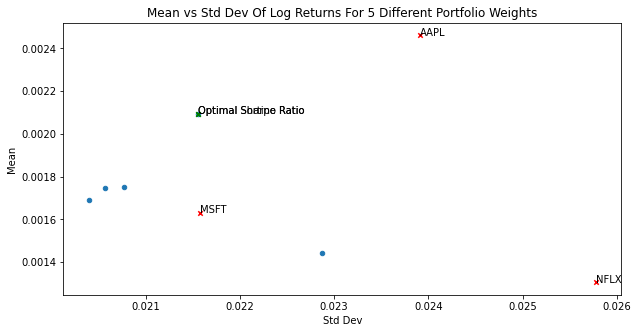

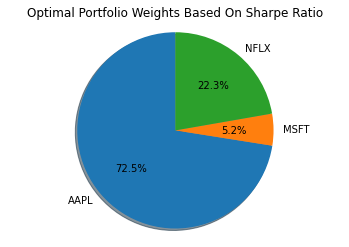

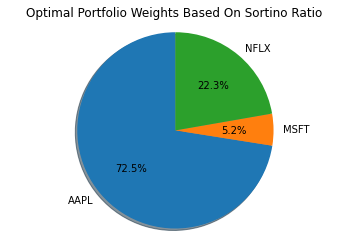

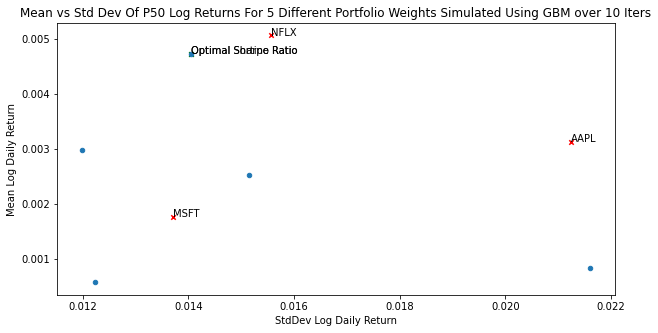

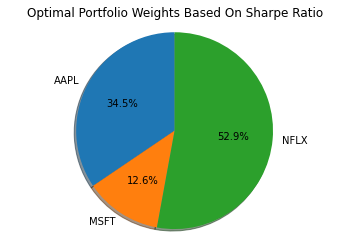

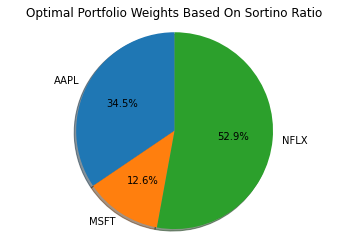

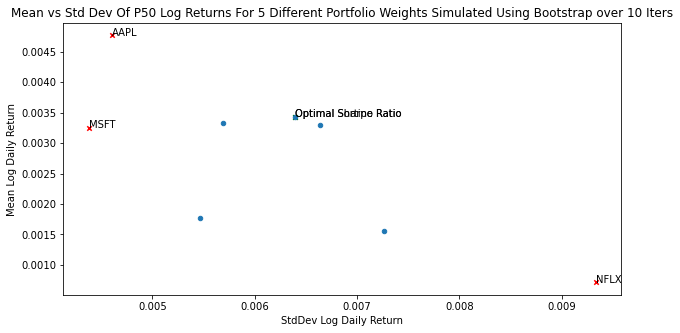

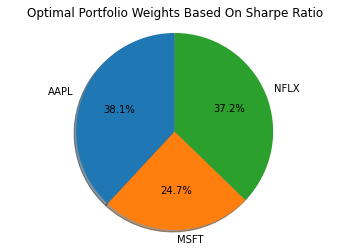

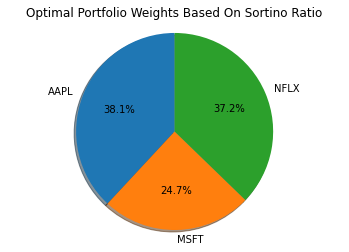

In [37]:
from flask import Flask, render_template, url_for, request, session
import os

app = Flask(__name__)
app.config['SEND_FILE_MAX_AGE_DEFAULT'] = 0

@app.route('/')
def start():
    return render_template('index.html')

@app.route('/results', methods = ['POST'])
def results():
    imagecounter = str(random.randint(10000,99999))
    mainSelection=request.form['mainSelection']
    tickerPortfolio=request.form['tickerPortfolio']
    portfolioWeights=request.form['portfolioWeights']
    portfolioValue=request.form.get('portfolioValue',type=float)
    StartDate = request.form['StartDate'] 
    EndDate=request.form['EndDate'] 
    ForecastDate=request.form['ForecastDate'] 
    BacktestDays=int(request.form['BacktestDays'])
    NoOfIter= int(request.form['NoOfIter'])
    PercentileRange= request.form['PercentileRange']
    averageType=request.form['AverageType']
    WindowSize1=int(request.form['WindowSize1'])
    WindowSize2=int(request.form['WindowSize2'])
    WindowSize3=int(request.form['WindowSize3'])
    noOfStdDev=int(request.form['noOfStdDev'])
    riskfreerate=request.form.get('riskfreerate',type=float)
    simMethod=request.form['simMethod']
    seasonality=int(request.form['seasonality'])

    if mainSelection=="candlestickChart":
        clear_cache('candlesticks')
        symbols=tickerPortfolio.split(",")
        plot_candlesticks(symbols,StartDate,EndDate,imagecounter,"candlesticks")
        
        hists = os.listdir('static/candlesticks')
        hists = ['candlesticks/' + file for file in hists]
        
        analysistype="Candlestick Chart"      
        
        return render_template('results.html',analysistype=analysistype, hists = hists, mainSelection=mainSelection,\
                               tickerPortfolio=tickerPortfolio,portfolioWeights=portfolioWeights,\
                               portfolioValue=portfolioValue,StartDate=StartDate,EndDate=EndDate,ForecastDate=ForecastDate,\
                               BacktestDays=BacktestDays,NoOfIter=NoOfIter,PercentileRange=PercentileRange,\
                               averageType=averageType,WindowSize1=WindowSize1,WindowSize2=WindowSize2,WindowSize3=WindowSize3,riskfreerate=riskfreerate,simMethod=simMethod\
                               )
    
    elif mainSelection=="RSIChart":
        clear_cache('relativestrengthindex')
        symbols=tickerPortfolio.split(",")
        plot_RSI(symbols,StartDate,EndDate,WindowSize1,averageType,imagecounter,"relativestrengthindex")
        
        hists = os.listdir('static/relativestrengthindex')
        hists = ['relativestrengthindex/' + file for file in hists]
        
        analysistype="Relative Strength Index Using "+averageType+" With Period Of "+str(WindowSize1)+" Days"      
        
        return render_template('results.html',analysistype=analysistype, hists = hists, mainSelection=mainSelection,\
                               tickerPortfolio=tickerPortfolio,portfolioWeights=portfolioWeights,\
                               portfolioValue=portfolioValue,StartDate=StartDate,EndDate=EndDate,ForecastDate=ForecastDate,\
                               BacktestDays=BacktestDays,NoOfIter=NoOfIter,PercentileRange=PercentileRange,\
                               averageType=averageType,WindowSize1=WindowSize1,WindowSize2=WindowSize2,WindowSize3=WindowSize3,riskfreerate=riskfreerate,simMethod=simMethod\
                               )
    
    elif mainSelection=="MACDChart":
        clear_cache('macd')
        symbols=tickerPortfolio.split(",")
        plot_MACD(StartDate,EndDate,symbols,WindowSize1,WindowSize2,WindowSize3,imagecounter,"macd")     
        
        hists = os.listdir('static/macd')
        hists = ['macd/' + file for file in hists]
        
        analysistype="Moving Average Convergence Divergence Using "+averageType+" With Periods Of "+str(WindowSize1)+" & "+str(WindowSize2)+" Days"      
        
        return render_template('results.html',analysistype=analysistype, hists = hists, mainSelection=mainSelection,\
                               tickerPortfolio=tickerPortfolio,portfolioWeights=portfolioWeights,\
                               portfolioValue=portfolioValue,StartDate=StartDate,EndDate=EndDate,ForecastDate=ForecastDate,\
                               BacktestDays=BacktestDays,NoOfIter=NoOfIter,PercentileRange=PercentileRange,\
                               averageType=averageType,WindowSize1=WindowSize1,WindowSize2=WindowSize2,WindowSize3=WindowSize3,riskfreerate=riskfreerate,simMethod=simMethod\
                               )
    
    elif mainSelection=="BBChart":
        clear_cache('bollingerbands')
        symbols=tickerPortfolio.split(",")
        plot_bollingerbands(symbols,StartDate,EndDate,WindowSize1,noOfStdDev,imagecounter,'bollingerbands')
        
        hists = os.listdir('static/bollingerbands')
        hists = ['bollingerbands/' + file for file in hists]
        
        analysistype="Bollinger Bands Using SMA Period Of "+str(WindowSize1)+" Days & Bands Reflecting "+str(noOfStdDev)+" Std Dev-s"      
        
        return render_template('results.html',analysistype=analysistype, hists = hists, mainSelection=mainSelection,\
                               tickerPortfolio=tickerPortfolio,portfolioWeights=portfolioWeights,\
                               portfolioValue=portfolioValue,StartDate=StartDate,EndDate=EndDate,ForecastDate=ForecastDate,\
                               BacktestDays=BacktestDays,NoOfIter=NoOfIter,PercentileRange=PercentileRange,\
                               averageType=averageType,WindowSize1=WindowSize1,WindowSize2=WindowSize2,WindowSize3=WindowSize3,riskfreerate=riskfreerate,simMethod=simMethod\
                               )
    
    elif mainSelection=="MovingAve":
        clear_cache('movingaverage')
        symbols=tickerPortfolio.split(",")
        portfolioWeights_func=portfolioWeights.split(",")
        portfolioWeights_func=[float(x) * 0.01 for x in portfolioWeights_func]
                
        T=np.busday_count(EndDate,ForecastDate)+BacktestDays
        N=T+1
        
        plotpiechart(symbols,portfolioWeights_func,imagecounter,"movingaverage")

        resultantDF, RMSE_DF, share_split_table=movingaverageforecast(StartDate,EndDate,BacktestDays,symbols,portfolioWeights_func,\
                                                   portfolioValue,T,N,averageType,WindowSize1,imagecounter,"movingaverage")        
        
        tableOne=RMSE_DF
        
        tailsDF=pd.DataFrame()
        for i in range(0,len(resultantDF)):
            tailsDF=pd.concat([tailsDF,resultantDF[i].tail(60)],axis=1)
        tableTwo=tailsDF
        tableThree=share_split_table
        
        hists = os.listdir('static/movingaverage')
        hists = ['movingaverage/' + file for file in hists]
        
        analysistype="Moving Average Forecast Using "+averageType+" With Period Of "+str(WindowSize1)+" Days"      
        
        return render_template('results.html',analysistype=analysistype, hists = hists, mainSelection=mainSelection,\
                               tickerPortfolio=tickerPortfolio,portfolioWeights=portfolioWeights,\
                               portfolioValue=portfolioValue,StartDate=StartDate,EndDate=EndDate,ForecastDate=ForecastDate,\
                               BacktestDays=BacktestDays,NoOfIter=NoOfIter,PercentileRange=PercentileRange,\
                               averageType=averageType,WindowSize1=WindowSize1,WindowSize2=WindowSize2,WindowSize3=WindowSize3,riskfreerate=riskfreerate,simMethod=simMethod,\
                              tableOne=[tableOne.to_html(classes='data', header="true")],\
                              tableTwo=[tableTwo.to_html(classes='data', header="true")],\
                              tableThree=[tableThree.to_html(classes='data', header="true")])

    
    elif mainSelection=="ARIMAGARCH":
        clear_cache('arimagarch')
        symbols=tickerPortfolio.split(",")
        portfolioWeights_func=portfolioWeights.split(",")
        portfolioWeights_func=[float(x) * 0.01 for x in portfolioWeights_func]
                
        T=np.busday_count(EndDate,ForecastDate)+BacktestDays
        N=T+1
        
        plotpiechart(symbols,portfolioWeights_func,imagecounter,"arimagarch")
        
        resultantDF, RMSE_DF, share_split_table =UnivarArimaGarchPredict(StartDate,EndDate,BacktestDays,\
                                                      symbols,portfolioWeights_func,portfolioValue,T,N,imagecounter,"arimagarch")
        
        
        tableOne=RMSE_DF
        tailsDF=pd.DataFrame()
        for i in range(0,len(resultantDF)):
            tailsDF=pd.concat([tailsDF,resultantDF[i].tail(60)],axis=1)
        tableTwo=tailsDF
        tableThree=share_split_table
        
        hists = os.listdir('static/arimagarch')
        hists = ['arimagarch/' + file for file in hists]
        
        analysistype="Univariate Auto-ARIMA + GARCH(1,1) Forecast"      
        
        return render_template('results.html',analysistype=analysistype, hists = hists, mainSelection=mainSelection,\
                               tickerPortfolio=tickerPortfolio,portfolioWeights=portfolioWeights,\
                               portfolioValue=portfolioValue,StartDate=StartDate,EndDate=EndDate,ForecastDate=ForecastDate,\
                               BacktestDays=BacktestDays,NoOfIter=NoOfIter,PercentileRange=PercentileRange,\
                               averageType=averageType,WindowSize1=WindowSize1,WindowSize2=WindowSize2,WindowSize3=WindowSize3,riskfreerate=riskfreerate,simMethod=simMethod,\
                              tableOne=[tableOne.to_html(classes='data', header="true")],\
                              tableTwo=[tableTwo.to_html(classes='data', header="true")],\
                              tableThree=[tableThree.to_html(classes='data', header="true")])


    elif mainSelection=="HoltWinters":
        clear_cache('holtwinters')
        symbols=tickerPortfolio.split(",")
        portfolioWeights_func=portfolioWeights.split(",")
        portfolioWeights_func=[float(x) * 0.01 for x in portfolioWeights_func]
                
        T=np.busday_count(EndDate,ForecastDate)+BacktestDays
        N=T+1
        
        plotpiechart(symbols,portfolioWeights_func,imagecounter,"holtwinters")  
        
        FinalOutput,FinalOutputTailTable,BestConfigSummaryTable,OptimalRMSESummaryTable,OverallRMSEforConfigTable  =AutoHoltWinters(StartDate,EndDate,ForecastDate,BacktestDays,\
                                                        symbols,portfolioWeights_func,portfolioValue,seasonality,imagecounter,'holtwinters')
        
        tableOne=OptimalRMSESummaryTable
        tableTwo=FinalOutputTailTable
        tableThree=BestConfigSummaryTable
        
        hists = os.listdir('static/holtwinters')
        hists = ['holtwinters/' + file for file in hists]
        
        analysistype="Triple Exponential Smoothing"      
        
        return render_template('results.html',analysistype=analysistype, hists = hists, mainSelection=mainSelection,\
                               tickerPortfolio=tickerPortfolio,portfolioWeights=portfolioWeights,\
                               portfolioValue=portfolioValue,StartDate=StartDate,EndDate=EndDate,ForecastDate=ForecastDate,\
                               BacktestDays=BacktestDays,NoOfIter=NoOfIter,PercentileRange=PercentileRange,\
                               averageType=averageType,WindowSize1=WindowSize1,WindowSize2=WindowSize2,WindowSize3=WindowSize3,riskfreerate=riskfreerate,simMethod=simMethod,\
                              tableOne=[tableOne.to_html(classes='data', header="true")],\
                              tableTwo=[tableTwo.to_html(classes='data', header="true")],\
                              tableThree=[tableThree.to_html(classes='data', header="true")])
    
    
    elif mainSelection=="VecAR":
        clear_cache('vectorautoreg')
        symbols=tickerPortfolio.split(",")
        portfolioWeights_func=portfolioWeights.split(",")
        portfolioWeights_func=[float(x) * 0.01 for x in portfolioWeights_func]
        
        plotpiechart(symbols,portfolioWeights_func,imagecounter,"vectorautoreg")
        
        stockprices,RMSE_DF,DWTable,GrangersMatrix,JohansonCointTable=vectorAutoRegression(StartDate,EndDate,\
                        symbols,portfolioWeights_func,portfolioValue,ForecastDate,BacktestDays,imagecounter,"vectorautoreg")


        
        tableOne=RMSE_DF
        tableTwo=stockprices.tail(60)
        tableThree=GrangersMatrix
        tableFour=JohansonCointTable
        tableFive=DWTable
        
        hists = os.listdir('static/vectorautoreg')
        hists = ['vectorautoreg/' + file for file in hists]
        
        if len(symbols)>1:
            analysistype="Multivariate Vector Auto Regression Forecast"
        elif len(symbols)==1:
            analysistype="ERROR ! Vector Auto Regression Forecast Requires Multi Variate Time Series Data"
        
        return render_template('resultsVecar.html',analysistype=analysistype, hists = hists, mainSelection=mainSelection,\
                               tickerPortfolio=tickerPortfolio,portfolioWeights=portfolioWeights,\
                               portfolioValue=portfolioValue,StartDate=StartDate,EndDate=EndDate,ForecastDate=ForecastDate,\
                               BacktestDays=BacktestDays,NoOfIter=NoOfIter,PercentileRange=PercentileRange,\
                               averageType=averageType,WindowSize1=WindowSize1,WindowSize2=WindowSize2,WindowSize3=WindowSize3,riskfreerate=riskfreerate,simMethod=simMethod,\
                              tableOne=[tableOne.to_html(classes='data', header="true")],\
                              tableTwo=[tableTwo.to_html(classes='data', header="true")],\
                              tableThree=[tableThree.to_html(classes='data', header="true")],\
                              tableFour=[tableFour.to_html(classes='data', header="true")],\
                              tableFive=[tableFive.to_html(classes='data', header="true")])
 
        
    elif mainSelection=="returnsDist":
        clear_cache('analysis')
        symbols=tickerPortfolio.split(",")
        portfolioWeights_func=portfolioWeights.split(",")
        portfolioWeights_func=[float(x) * 0.01 for x in portfolioWeights_func]
        
        dfprices, noOfShares, share_split_table = extract_prices(StartDate,EndDate,symbols,portfolioWeights_func,portfolioValue)
        
        dfreturns ,df_mean_stdev=calc_returns(dfprices,symbols)
        
        plotpiechart(symbols,portfolioWeights_func,imagecounter,"analysis")
        plotprices(dfprices,symbols,imagecounter,"analysis")
        plotreturns(dfreturns,imagecounter,"analysis")
        KSTestResultsDF, ShapiroWilkTestResultsDF , Kurtosis_Skew, ADFTestResultsDF = fit_test_normal(dfreturns,symbols,imagecounter,"analysis")
        StartMidEndDF =compareStartMidEnd(dfreturns,df_mean_stdev)
        
        hists = os.listdir('static/analysis')
        hists = ['analysis/' + file for file in hists]
        
        tableOne=df_mean_stdev
        tableTwo=KSTestResultsDF
        tableThree=Kurtosis_Skew
        tableFour=dfreturns.corr()
        tableFive=ADFTestResultsDF
        tableSix=StartMidEndDF
        analysistype="Detailed Analysis Of Log Returns"      
        
        
        return render_template('resultsLogreturns.html',analysistype=analysistype, hists = hists, mainSelection=mainSelection,\
                               tickerPortfolio=tickerPortfolio,portfolioWeights=portfolioWeights,\
                               portfolioValue=portfolioValue,StartDate=StartDate,EndDate=EndDate,ForecastDate=ForecastDate,\
                               BacktestDays=BacktestDays,NoOfIter=NoOfIter,PercentileRange=PercentileRange,\
                               averageType=averageType,WindowSize1=WindowSize1,WindowSize2=WindowSize2,WindowSize3=WindowSize3,riskfreerate=riskfreerate,simMethod=simMethod,\
                              tableOne=[tableOne.to_html(classes='data', header="true")],\
                              tableTwo=[tableTwo.to_html(classes='data', header="true")],\
                              tableThree=[tableThree.to_html(classes='data', header="true")],\
                              tableFour=[tableFour.to_html(classes='data', header="true")],\
                              tableFive=[tableFive.to_html(classes='data', header="true")],\
                              tableSix=[tableSix.to_html(classes='data', header="true")])
        
    elif mainSelection=="GBM":
        clear_cache('gbm_bootstrap')
        symbols=tickerPortfolio.split(",")
        portfolioWeights_func=portfolioWeights.split(",")
        portfolioWeights_func=[float(x) * 0.01 for x in portfolioWeights_func]
        
        plotpiechart(symbols,portfolioWeights_func,imagecounter,"gbm_bootstrap")
        
        T=np.busday_count(EndDate,ForecastDate)+BacktestDays
        N=T+1
        
        final, share_split_tableFULL , dfreturns , df_mean_stdev , ReturnsAtForecastEndDate, dfprices = MonteCarlo_GBM(StartDate,EndDate,BacktestDays,PercentileRange,symbols,\
                       portfolioWeights_func,portfolioValue,T,N,NoOfIter,imagecounter,"gbm_bootstrap")
        
        if BacktestDays>0:
            tableOne=calculateRMSE(final,T,BacktestDays,dfprices)
            
        elif BacktestDays<=0:
            tableOne=pd.DataFrame()
                    
        hists = os.listdir('static/gbm_bootstrap')
        hists = ['gbm_bootstrap/' + file for file in hists]
        
        GBMtail=pd.concat([final[final.columns[0:(len(symbols)+1)]].tail(60),final[final.columns[-3*(len(symbols)+1):]].tail(60)],axis=1)
        GBMtail=GBMtail.round(2) 
        
        tableTwo=GBMtail
        tableThree=ReturnsAtForecastEndDate
        tableFour=dfreturns.corr()
        tableFive=share_split_tableFULL
        
        analysistype="Forecast Of Future Price Values For Portfolio Based On Geometric Brownian Motion"
        
        return render_template('results.html',analysistype=analysistype, hists = hists, mainSelection=mainSelection,\
                               tickerPortfolio=tickerPortfolio,portfolioWeights=portfolioWeights,\
                               portfolioValue=portfolioValue,StartDate=StartDate,EndDate=EndDate,ForecastDate=ForecastDate,\
                               BacktestDays=BacktestDays,NoOfIter=NoOfIter,PercentileRange=PercentileRange,\
                               averageType=averageType,WindowSize1=WindowSize1,WindowSize2=WindowSize2,WindowSize3=WindowSize3,riskfreerate=riskfreerate,simMethod=simMethod,\
                              tableOne=[tableOne.to_html(classes='data', header="true")],\
                              tableTwo=[tableTwo.to_html(classes='data', header="true")],\
                              tableThree=[tableThree.to_html(classes='data', header="true")],\
                              tableFour=[tableFour.to_html(classes='data', header="true")],\
                              tableFive=[tableFive.to_html(classes='data', header="true")])
    
   
    elif mainSelection=="Bootstrap":
        clear_cache('gbm_bootstrap')
        symbols=tickerPortfolio.split(",")
        portfolioWeights_func=portfolioWeights.split(",")
        portfolioWeights_func=[float(x) * 0.01 for x in portfolioWeights_func]
        
        plotpiechart(symbols,portfolioWeights_func,imagecounter,"gbm_bootstrap")
                
        T=np.busday_count(EndDate,ForecastDate)+BacktestDays
        N=T+1
        
        final, share_split_tableFULL , dfreturns , df_mean_stdev , ReturnsAtForecastEndDate,dfprices = MonteCarlo_Bootstrap(StartDate,EndDate,BacktestDays,PercentileRange,symbols,\
                       portfolioWeights_func,portfolioValue,T,N,NoOfIter,imagecounter,"gbm_bootstrap")
        
        if BacktestDays>0:
            tableOne=calculateRMSE(final,T,BacktestDays,dfprices)
            
        elif BacktestDays<=0:
            tableOne=pd.DataFrame()
            
        hists = os.listdir('static/gbm_bootstrap')
        hists = ['gbm_bootstrap/' + file for file in hists]
        
        Bootstraptail=pd.concat([final[final.columns[0:(len(symbols)+1)]].tail(60),final[final.columns[-3*(len(symbols)+1):]].tail(60)],axis=1)
        Bootstraptail=Bootstraptail.round(2) 
        
        tableTwo=Bootstraptail
        tableThree=ReturnsAtForecastEndDate
        tableFour=dfreturns.corr()
        tableFive=share_split_tableFULL
        
        analysistype="Forecast Of Future Price Values For Portfolio Based On Bootstrap Sampling"
        
        return render_template('results.html',analysistype=analysistype, hists = hists, mainSelection=mainSelection,\
                               tickerPortfolio=tickerPortfolio,portfolioWeights=portfolioWeights,\
                               portfolioValue=portfolioValue,StartDate=StartDate,EndDate=EndDate,ForecastDate=ForecastDate,\
                               BacktestDays=BacktestDays,NoOfIter=NoOfIter,PercentileRange=PercentileRange,\
                               averageType=averageType,WindowSize1=WindowSize1,WindowSize2=WindowSize2,WindowSize3=WindowSize3,riskfreerate=riskfreerate,simMethod=simMethod,\
                              tableOne=[tableOne.to_html(classes='data', header="true")],\
                              tableTwo=[tableTwo.to_html(classes='data', header="true")],\
                              tableThree=[tableThree.to_html(classes='data', header="true")],\
                              tableFour=[tableFour.to_html(classes='data', header="true")],\
                              tableFive=[tableFive.to_html(classes='data', header="true")])
    

    elif mainSelection=="EfficientFrontierHist":
        clear_cache('efficientportfolio')
        symbols=tickerPortfolio.split(",")
        
        T=np.busday_count(EndDate,ForecastDate)+0
        N=T+1
                
        FinalResultsTable,SharpeDetail,SortinoDetail=EfficientPortfolioHistorical(StartDate,EndDate,symbols,portfolioValue,NoOfIter,riskfreerate,imagecounter,"efficientportfolio")
        
        HistSharpeWeights=FinalResultsTable.nlargest(1,['Sharpe Ratio'])['Weights'].tolist()

        HistSharpe_dfprices, HistSharpe_noOfShares, HistSharpe_share_split_table = extract_prices(StartDate,EndDate,symbols,HistSharpeWeights[0],portfolioValue)

        HistSharpe_dfreturns ,HistSharpe_df_mean_stdev=calc_returns(HistSharpe_dfprices,symbols)

        HistSharpe_df_mean_stdev["Mean Daily Return"]=np.exp(HistSharpe_df_mean_stdev["Mean Log Daily Return"])-1
        HistSharpe_df_mean_stdev["StdDev Daily Return"]=np.exp(HistSharpe_df_mean_stdev["StdDev Log Daily Return"])-1
        
        tableTwo=FinalResultsTable.nlargest(1,['Sharpe Ratio'])
        SharpeWeights=FinalResultsTable.nlargest(1,['Sharpe Ratio'])['Weights'].tolist()
        print(SharpeWeights[0])
      
        labels = symbols
        sizes = SharpeWeights[0]
        fig1, ax1 = plt.subplots()
        ax1.pie(SharpeWeights[0], labels=symbols, autopct='%1.1f%%',
            shadow=True, startangle=90)
        ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.title("Optimal Portfolio Weights Based On Sharpe Ratio")
        plt.savefig(f'static/efficientportfolio/{imagecounter}_01SharpePortfolioweights.png')
            
        tableThree=FinalResultsTable.nlargest(1,['Sortino Ratio'])
        SortinoWeights=FinalResultsTable.nlargest(1,['Sortino Ratio'])['Weights'].tolist()
        print(SortinoWeights[0])
        
        sizes = SortinoWeights[0]
        fig1, ax1 = plt.subplots()
        ax1.pie(SortinoWeights[0], labels=symbols, autopct='%1.1f%%',
            shadow=True, startangle=90)
        ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.title("Optimal Portfolio Weights Based On Sortino Ratio")
        plt.savefig(f'static/efficientportfolio/{imagecounter}_01SortinoPortfolioweights.png')
        
        tableFour=HistSharpe_df_mean_stdev
        
        hists = os.listdir('static/efficientportfolio')
        hists = ['efficientportfolio/' + file for file in hists]
        
        analysistype="Efficient Portfolio Weights Via Mean-Variance Analysis" 
        subheading="For Historical Period From "+StartDate+" To "+EndDate+" For Simulation Of "+str(NoOfIter)+" Iterations"
        
        return render_template('results.html',SharpeDetail=SharpeDetail,SortinoDetail=SortinoDetail,subheading=subheading,analysistype=analysistype, hists = hists, mainSelection=mainSelection,\
                               tickerPortfolio=tickerPortfolio,portfolioWeights=portfolioWeights,\
                               portfolioValue=portfolioValue,StartDate=StartDate,EndDate=EndDate,ForecastDate=ForecastDate,\
                               BacktestDays=BacktestDays,NoOfIter=NoOfIter,PercentileRange=PercentileRange,\
                               averageType=averageType,WindowSize1=WindowSize1,WindowSize2=WindowSize2,WindowSize3=WindowSize3,riskfreerate=riskfreerate,simMethod=simMethod,\
                              tableTwo=[tableTwo.to_html(classes='data', header="true")],\
                              tableThree=[tableThree.to_html(classes='data', header="true")],\
                              tableFour=[tableFour.to_html(classes='data', header="true")])    
    
    
    elif mainSelection=="EfficientFrontier":
        clear_cache('efficientportfolio')
        symbols=tickerPortfolio.split(",")
        
        T=np.busday_count(EndDate,ForecastDate)+0
        N=T+1
        
        NoOfIterationsInnerLoop=10 #Fixed to 10 to avoid time out error as algol is very time consuming
                
        FutureFinalResultsTable,FutureSharpeDetail,FutureSortinoDetail =EfficientPortfolioFuture(StartDate,EndDate,symbols,\
                                                                                                 portfolioValue,T,N,NoOfIter,\
                                                                                                 NoOfIterationsInnerLoop,\
                                                                                                 riskfreerate,simMethod,\
                                                                                                 imagecounter,\
                                                                                                 "efficientportfolio")
        
        FutureSharpeRatio_Best=pd.DataFrame(FutureFinalResultsTable.nlargest(1,['Sharpe Ratio'])["Components Log Returns Mean"].values[0],index=symbols,columns=["Mean Log Daily Return"])
        FutureSharpeRatio_Best["StdDev Log Daily Return"]=FutureFinalResultsTable.nlargest(1,['Sharpe Ratio'])["Components Log Returns Std Dev"].values[0]
        SharpeRatioFutureMEAN=FutureFinalResultsTable.nlargest(1,['Sharpe Ratio'])["Log Returns Mean"].values[0]
        SharpeRatioFutureSTDEV=FutureFinalResultsTable.nlargest(1,['Sharpe Ratio'])["Log Returns Std Dev"].values[0]

        FutureSharpeRatio_Best=FutureSharpeRatio_Best.append(pd.DataFrame([[SharpeRatioFutureMEAN,SharpeRatioFutureSTDEV]],index=["Portfolio"],columns=FutureSharpeRatio_Best.columns))

        FutureSharpeRatio_Best["Mean Daily Return"]=np.exp(FutureSharpeRatio_Best["Mean Log Daily Return"])-1
        FutureSharpeRatio_Best["StdDev Daily Return"]=np.exp(FutureSharpeRatio_Best["StdDev Log Daily Return"])-1

        
        tableTwo=FutureFinalResultsTable.nlargest(1,['Sharpe Ratio'])
        SharpeWeights=FutureFinalResultsTable.nlargest(1,['Sharpe Ratio'])['Weights'].tolist()
        print(SharpeWeights[0])
      
        labels = symbols
        sizes = SharpeWeights[0]
        fig1, ax1 = plt.subplots()
        ax1.pie(SharpeWeights[0], labels=symbols, autopct='%1.1f%%',
            shadow=True, startangle=90)
        ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.title("Optimal Portfolio Weights Based On Sharpe Ratio")
        plt.savefig(f'static/efficientportfolio/{imagecounter}_01SharpePortfolioweights.png')
            
        tableThree=FutureFinalResultsTable.nlargest(1,['Sortino Ratio'])
        SortinoWeights=FutureFinalResultsTable.nlargest(1,['Sortino Ratio'])['Weights'].tolist()
        print(SortinoWeights[0])
        
        sizes = SortinoWeights[0]
        fig1, ax1 = plt.subplots()
        ax1.pie(SortinoWeights[0], labels=symbols, autopct='%1.1f%%',
            shadow=True, startangle=90)
        ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.title("Optimal Portfolio Weights Based On Sortino Ratio")
        plt.savefig(f'static/efficientportfolio/{imagecounter}_01SortinoPortfolioweights.png')
        
        tableFour=FutureSharpeRatio_Best
        
        hists = os.listdir('static/efficientportfolio')
        hists = ['efficientportfolio/' + file for file in hists]
        
        analysistype="Efficient Portfolio Weights Via Mean-Variance Analysis" 
        subheading="For Forecast Period Of "+str(N)+" Days From "+EndDate+" Till "+ForecastDate+" Via "+simMethod+" Simulation Over "+str(NoOfIter)+" Iterations"
        
        return render_template('results.html',SharpeDetail=FutureSharpeDetail,SortinoDetail=FutureSortinoDetail,subheading=subheading,analysistype=analysistype, hists = hists, mainSelection=mainSelection,\
                               tickerPortfolio=tickerPortfolio,portfolioWeights=portfolioWeights,\
                               portfolioValue=portfolioValue,StartDate=StartDate,EndDate=EndDate,ForecastDate=ForecastDate,\
                               BacktestDays=BacktestDays,NoOfIter=NoOfIter,PercentileRange=PercentileRange,\
                               averageType=averageType,WindowSize1=WindowSize1,WindowSize2=WindowSize2,WindowSize3=WindowSize3,riskfreerate=riskfreerate,simMethod=simMethod,\
                              tableTwo=[tableTwo.to_html(classes='data', header="true")],\
                              tableThree=[tableThree.to_html(classes='data', header="true")],\
                              tableFour=[tableFour.to_html(classes='data', header="true")])  
            
if __name__ == '__main__':
    app.run(debug=True, use_reloader=False, port=5000)